<font color="82737a"><h3>EVALUACIÓN DE LOS MÓDULOS APRENDIZAJE PROFUNDO (I) Y (II) DEL MÁSTER EN IA DE LA UNIVERSITAT DE VALÈNCIA.</h3></font>

<font color="fff">Selene Campos Lérida</font>

---

<img src="https://elblogdezoe.es/galeria/414-big-dia-mundial-contra-el-cancer-de-mama-mas-de-200000-tuits.jpg" align="right" style="float" width="130">
<font color='e1adc0' size="4.5"><h1>Predicción del carcinoma ductal invasivo en cortes de imágenes hispatológicas mediante el uso redes neuronales convolucionales.</h1></font>
<br></br>

---


El carcinoma ductal invasivo (IDC) es el tipo más común de cáncer de mama. Aproximadamente 8 de 10 cánceres de seno son carcinomas ductales invasivos (o infiltrantes).

El IDC comienza en las células que revisten un conducto de leche en el seno. A partir de ahí, el cáncer invade la pared del conducto, y crece en los tejidos mamarios cercanos. En este punto puede tener la capacidad de propagarse (hacer metástasis) hacia otras partes del cuerpo a través del sistema linfático y el torrente sanguíneo.

A menudo, para diagnosticar el IDC, se realiza una biopsia para extraer pequeñas muestras de tejido. A partir de estas muestras, un patólogo tiene que decidir si la paciente tiene carcinoma ductal invasivo, otro tipo de cáncer o si está ana. Además, es necesario localizar las células enfermas para saber qué tan avanzada está la enfermedad y qué grado debe asignarse. 

Este proceso se realiza de forma manual y requiere mucho tiempo. Además, la decisión depende de la experiencia del patólogo y su equipo. Por lo tanto, el aprendizaje profundo podría ser de gran ayuda para detectar y localizar de forma más rápida las células del tejido tumoral y acelerar el proceso. 

#### Importación de bibliotecas

In [1]:
from glob import glob
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from skimage.io import imread
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import AveragePooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline

In [3]:
!pip install scikit-plot

#### Carga de datos

In [5]:
COLAB = True

In [6]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1TkDSdp5HGH0uIOZCbqZfKga3FYnQKt4C',
                                        dest_path='./breast_cancer.zip', unzip=True)

Unzipping...Done.


#### Estructurar los datos

El conjunto de datos original consistía en 162 imágenes de diapositivas de montaje completo de muestras de cáncer de mama escaneadas a 40x. 

De eso, se extrajeron 277,524 parches de tamaño 50 x 50 (198,738 IDC negativos y 78,786 IDC positivos). 

El nombre de archivo de cada parche tiene el formato: uxXyYclassC.png -> ejemplo 10253idx5x1351y1101class0.png. 

Donde:

* **u** es el ID del paciente (10253idx5).

* **X** es la coordenada x de donde se recortó este parche. 

* **Y** es la coordenada y de donde se recortó este parche.

* **C** indica la clase donde 0 no es IDC y 1 es IDC.



In [6]:
files = glob('archive-2/*/*/*.png', recursive=True)

In [4]:
files

[]

In [5]:
# Creamos un dataframe que contiene todas las características de los datos. 
df_EDA = pd.DataFrame(index=np.arange(0, len(files)), columns=["patient_ID", "coord_X", "coord_Y", "image", "path", "target"])

for i,f in enumerate(files):
    
    df_EDA.iloc[i]["patient_ID"] = int(f.rsplit("/")[1])
    df_EDA.iloc[i]["coord_X"] = int(f.rsplit("_")[2][1:])
    df_EDA.iloc[i]["coord_Y"] = int(f.rsplit("_")[3][1:])
    df_EDA.iloc[i]["image"] = imread(f)
    df_EDA.iloc[i]["path"] = f
    df_EDA.iloc[i]["target"] = int(f[-5])

df_EDA.head()

Empty DataFrame
Columns: [patient_ID, coord_X, coord_Y, image, path, target]
Index: []

In [7]:
# Creamos un dataframe que contiene la ruta de la imágen y la variabble objetivo.
df_model = pd.DataFrame(index=np.arange(0, len(files)), columns=["patient_ID", "path", "target"])

for i,f in enumerate(files):
    
    df_model.iloc[i]["patient_ID"] = int(f.rsplit("/")[1])
    df_model.iloc[i]["path"] = f
    df_model.iloc[i]["target"] = f[-5]

df_model.head()

patient_ID                                               path target
0       9036  archive-2/9036/0/9036_idx5_x1051_y2401_class0.png      0
1       9036   archive-2/9036/0/9036_idx5_x2951_y951_class0.png      0
2       9036  archive-2/9036/0/9036_idx5_x3001_y1451_class0.png      0
3       9036   archive-2/9036/0/9036_idx5_x3051_y801_class0.png      0
4       9036   archive-2/9036/0/9036_idx5_x951_y1901_class0.png      0

# Análisis exploratorio de los datos
El conjunto de datos que disponemos está compuesto por cortes de imágenes histológicas que pertenecen a 279 pacientes. Además, conocemos las coordenadas X e Y de cada corte. Por lo que es posible reconstruir la imágen original.

In [7]:
print("Número de pacientes", len(df_EDA.patient_ID.unique()))
print("Número de cortes de imágenes", df_EDA.shape[0])

Número de pacientes 279
Número de cortes de imágenes 277524


In [61]:
# Comprobar si hay datos nulos
df_EDA.isnull().sum().sum()

0

In [62]:
print("Las cordenadas X van de", df_EDA.coord_X.min(), "a", df_EDA.coord_X.max())
print("Las cordenadas Y van de", df_EDA.coord_Y.min(), "a", df_EDA.coord_Y.max())

Las cordenadas X van de 1 a 4001
Las cordenadas Y van de 1 a 2951


In [130]:
df_EDA["shape"] = df_EDA["image"].transform(lambda x: x.shape)
df_EDA["shape"].unique()

array([(50, 50, 3), (30, 50, 3), (15, 50, 3), (15, 42, 3), (42, 50, 3),
       (42, 32, 3), (4, 50, 3), (50, 42, 3), (41, 50, 3), (41, 41, 3),
       (25, 50, 3), (25, 5, 3), (50, 11, 3), (49, 50, 3), (50, 41, 3),
       (37, 50, 3), (1, 50, 3), (10, 50, 3), (20, 50, 3), (13, 50, 3),
       (13, 32, 3), (39, 50, 3), (50, 12, 3), (9, 50, 3), (5, 50, 3),
       (40, 50, 3), (40, 22, 3), (48, 50, 3), (14, 50, 3), (16, 50, 3),
       (50, 46, 3), (48, 46, 3), (11, 50, 3), (50, 32, 3), (28, 50, 3),
       (23, 50, 3), (50, 22, 3), (17, 50, 3), (50, 31, 3), (47, 50, 3),
       (19, 50, 3), (33, 50, 3), (31, 50, 3), (2, 50, 3), (38, 50, 3),
       (38, 36, 3), (50, 36, 3), (50, 21, 3), (3, 50, 3), (36, 50, 3),
       (27, 50, 3), (43, 12, 3), (1, 42, 3), (23, 2, 3), (38, 12, 3),
       (34, 50, 3), (43, 50, 3), (43, 5, 3), (44, 50, 3), (45, 50, 3),
       (34, 21, 3), (41, 42, 3), (35, 50, 3), (8, 50, 3), (7, 50, 3),
       (41, 16, 3), (26, 50, 3), (26, 2, 3), (50, 26, 3), (6, 26, 3),
      

In [131]:
df_EDA["shape"].value_counts()

(50, 50, 3)    275222
(42, 50, 3)       176
(41, 50, 3)       146
(27, 50, 3)       144
(38, 50, 3)       125
                ...  
(48, 46, 3)         1
(15, 42, 3)         1
(9, 50, 3)          1
(26, 2, 3)          1
(13, 32, 3)         1
Name: shape, Length: 79, dtype: int64

Como se puede observar, no todas las imágenes tienen el mismo tamaño, aunque la mayoria son de 50x50px y multicanal.

En este conjunto de datos tenemos 279 pacientes, de cada uno de ello hay cortes o parches de imágenes dónde se determina que parte del tejido tiene cáncer.

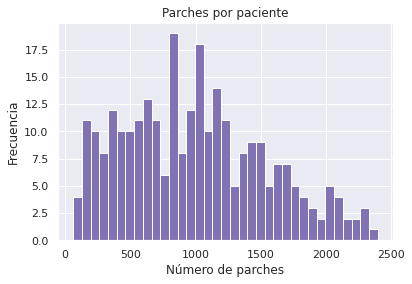

In [ ]:
# Cuántos parches hay por imágen?
patches_per_patient = df_EDA.groupby("patient_ID").size()

fig, ax = plt.subplots()

plt.hist(patches_per_patient, color="m", bins=35)
ax.set_xlabel("Número de parches")
ax.set_ylabel("Frecuencia")
ax.set_title("Parches por paciente")

plt.show()

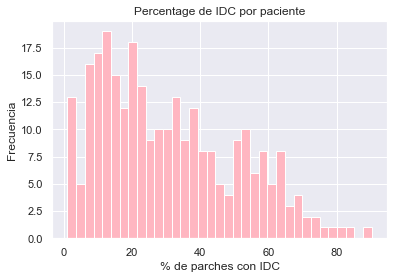

In [224]:
# Qué porcentage de IDC hay por imagen
patches_IDC = (df_EDA.groupby("patient_ID").target.value_counts() / df_EDA.groupby("patient_ID").target.size())[:,1]

fig, ax = plt.subplots()

plt.hist(patches_IDC*100, color="lightpink", bins=35)
ax.set_xlabel("% de parches con IDC")
ax.set_ylabel("Frecuencia")
ax.set_title("Percentage de IDC por paciente")

plt.show()

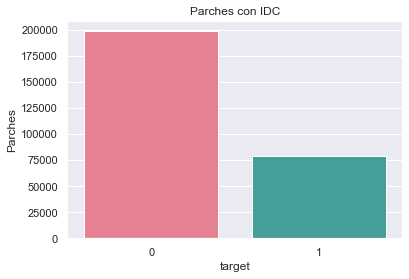

In [225]:
# Cantidad de patrones con IDC
cancer_patch = (df_EDA["target"] == 0).sum() / df_EDA.shape[0]
healthy_patch = (df_EDA["target"] == 1).sum() / df_EDA.shape[0]

fig, ax = plt.subplots()

sns.countplot(x="target", data=df_EDA, palette="husl", ax=ax)
ax.set_ylabel("Parches")
ax.set_title("Parches con IDC")

plt.show()

* El número de parches por imagen varia mucho.
* En algunos pacientes el 80% de la imágen histológica está cubierta por IDC
* Las clases están desbalanceadas. Posiblemente habrá que aumentar los datos.

#### Visualización de las imágenes

In [215]:
# Seleccionamos 36 parches de cada clase
healthy_patches = np.random.choice(df_EDA[df_EDA['target']==0].image, size=36)
cancer_patches = np.random.choice(df_EDA[df_EDA['target']==1].image, size=36)
  

In [212]:
def montage2d(data):
    n = len(data)
    height = int(np.ceil(np.sqrt(n)))
    height_1, width_1 = data[0].shape[:-1]
    aux = np.zeros((height*height_1, height*width_1, 3))
    for i,image in enumerate(data):
        row = i // height
        col = i % height
        aux[(row*height_1):((row+1)*height_1), (col*width_1):((col+1)*width_1), :] = image
    aux = aux.astype('uint8')
    return aux

In [213]:
def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)

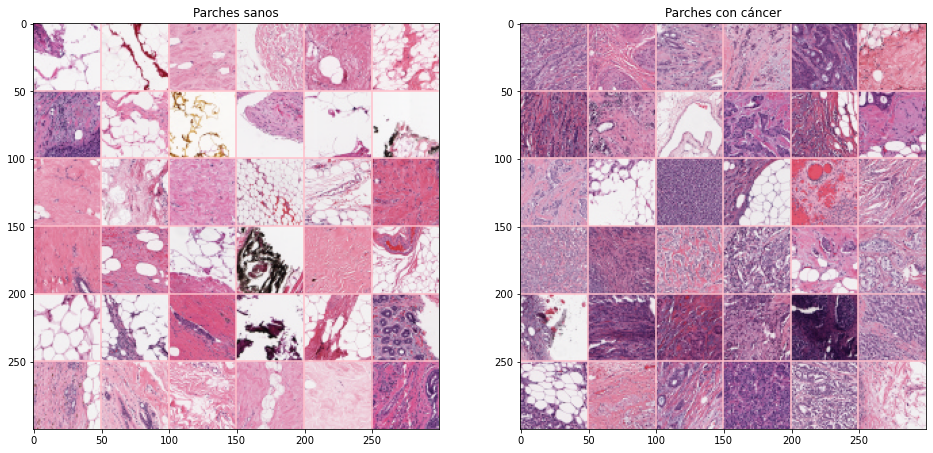

In [216]:
size = 36
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))

ax1.imshow(montage2d(healthy_patches))
ax1.set_title('Parches sanos')
draw_borders(ax1, size, healthy_patches[0].shape[0], healthy_patches[0].shape[1], 'pink')

ax2.imshow(montage2d(cancer_patches))
ax2.set_title('Parches con cáncer')
draw_borders(ax2, size, cancer_patches[0].shape[0], cancer_patches[0].shape[1], 'pink');

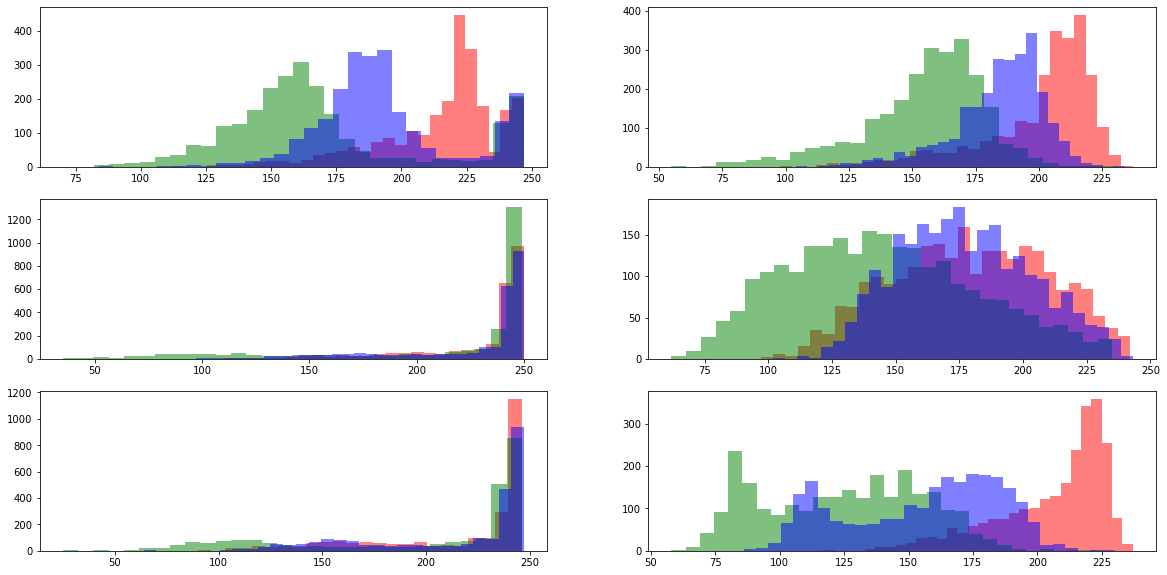

In [217]:
fig, ax = plt.subplots(3,2, figsize=(20,10))
ax = ax.ravel()
healthy_p = np.random.choice(healthy_patches, size=3)
cancer_p = np.random.choice(cancer_patches, size=3)

for i in range(3):
    n = i*2
    ax[n].hist(healthy_p[i][:, :, 0].ravel(), bins = 30, color = 'red', alpha = 0.5)
    ax[n].hist(healthy_p[i][:, :, 1].ravel(), bins = 30, color = 'green', alpha = 0.5)
    ax[n].hist(healthy_p[i][:, :, 2].ravel(), bins = 30, color = 'blue', alpha = 0.5)
    
    ax[n+1].hist(cancer_p[i][:, :, 0].ravel(), bins = 30, color = 'red', alpha = 0.5)
    ax[n+1].hist(cancer_p[i][:, :, 1].ravel(), bins = 30, color = 'green', alpha = 0.5)
    ax[n+1].hist(cancer_p[i][:, :, 2].ravel(), bins = 30, color = 'blue', alpha = 0.5)


A primera vista, da la sensación de que las imágenes que tienen IDC son más moradas.


#### Pacientes
Como hemos visto anteriormente, cononcemos las coordenads de los parches. Por lo que vamos a montarlas reconstruyendo así la hispatología de cada paciente.

In [153]:
def breast_tissue(patient_id, breast_df):
    patient_df = breast_df[breast_df["patient_ID"] == patient_id]

    # calculate max points
    max_point = [patient_df.coord_Y.max()-1, patient_df.coord_X.max()-1]
    # initialize white matrix
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)

    broken_patches=[]
    for i,image in enumerate(patient_df.image):
        image = patient_df.iloc[i].image
        target = patient_df.iloc[i].target

        x_coord = patient_df.iloc[i].coord_X
        y_coord = patient_df.iloc[i].coord_Y
        x_start = x_coord - 1
        y_start = y_coord - 1
        x_end = x_start + image.shape[1]
        y_end = y_start + image.shape[0]

        if target == 1:
            mask[y_start:y_end, x_start:x_end, 0] = 200
            mask[y_start:y_end, x_start:x_end, 1] = 0
            mask[y_start:y_end, x_start:x_end, 2] = 150

        grid[y_start:y_end, x_start:x_end, :] = image 

    return [grid, mask]

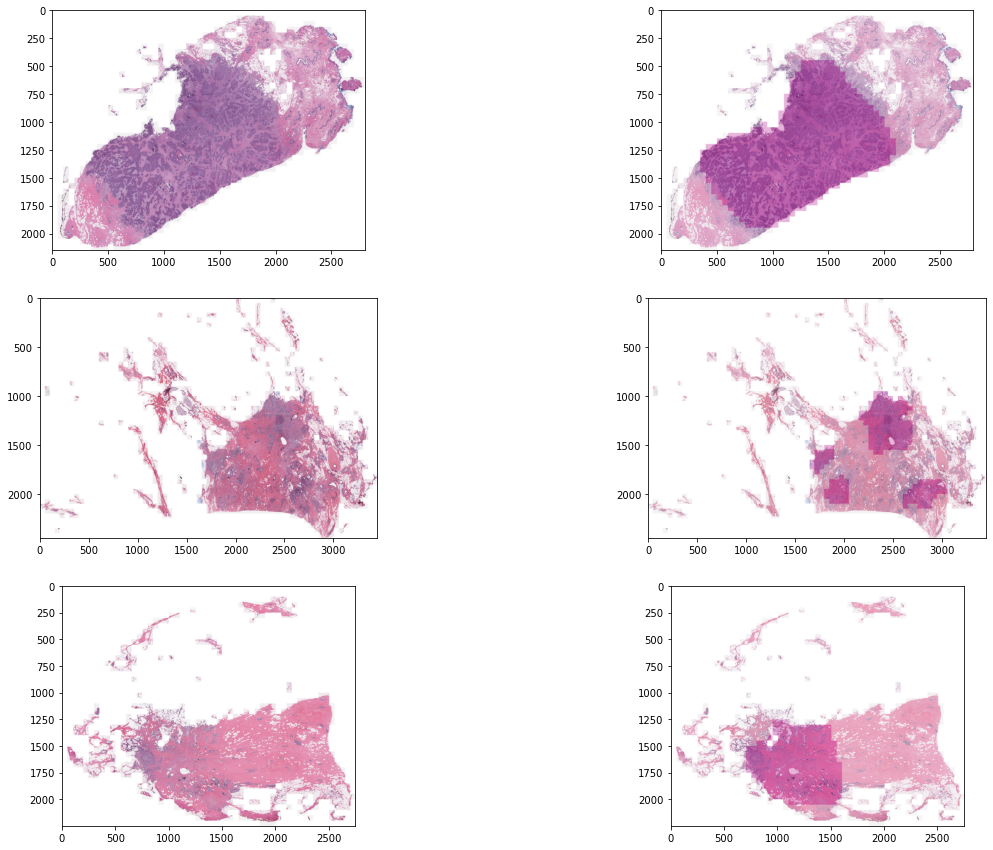

In [158]:
fig, ax = plt.subplots(3,2,figsize=(20,15))
ax = ax.ravel()

patient = np.random.choice(df_EDA['patient_ID'], size=3)

for i in range(3):
    grid, mask = breast_tissue(patient[i],df_EDA)
    n=i*2
    ax[n].imshow(grid, alpha=0.9)
    ax[n+1].imshow(mask, alpha=0.8)
    ax[n+1].imshow(grid, alpha=0.7)
    
plt.show()

En las imágenes que están a la izquierda se puede observar el tejido mamario de algunas pacientes, y a la izquierda se observa la misma imagen con la zona que tiene IDC marcada en morado.
Las imagenes son de diferentes tamaños y no están completas.

# Configuración del flujo de trabajo
Vamos a dividir el conjunto de datos en entrenamiento y test. Para ello usaremos el 25% para test y el 75% de pacientes para el entrenamiento y validación, de esta manera se pretende que haya variedad de datos en cada conjunto.

In [8]:
patients = df_model.patient_ID.unique()

In [9]:
train_ids, test_ids = train_test_split(patients,
                                        shuffle=True, 
                                        test_size=0.25, 
                                        random_state=0)
train_ids, val_ids = train_test_split(train_ids,
                                        shuffle=True, 
                                        test_size=0.25, 
                                        random_state=0)

In [10]:
df_train = df_model[df_model["patient_ID"].isin(train_ids)]
df_val = df_model[df_model["patient_ID"].isin(val_ids)]
df_test = df_model[df_model["patient_ID"].isin(test_ids)]

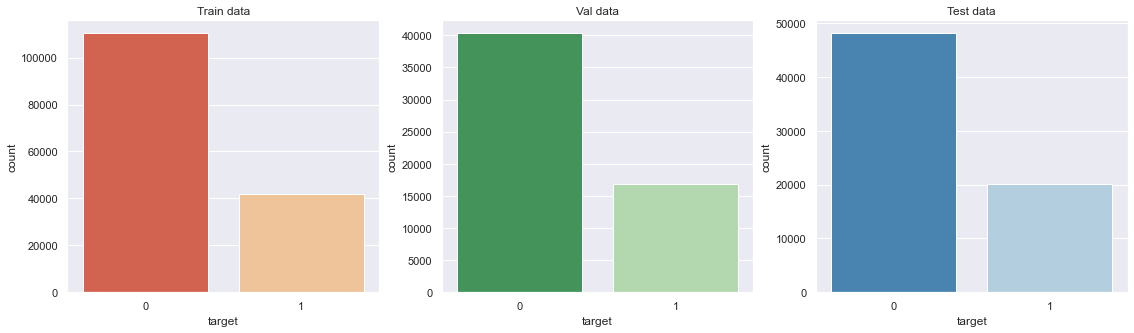

In [11]:
#### Distribución de los datos 
fig, ax = plt.subplots(1,3,figsize=(19,5))
sns.countplot(x="target", data=df_train, ax=ax[0], palette="OrRd_r")
ax[0].set_title("Train data")
sns.countplot(x="target", data=df_val, ax=ax[1], palette="Greens_r")
ax[1].set_title("Val data")
sns.countplot(x="target", data=df_test, palette="Blues_r")
ax[2].set_title("Test data")
plt.show()

En los tres conjuntos de datos hay más del doble de parches sin IDC. Para balancear los datos en los conjuntos de entrenamiento y validación vamos aumen

In [12]:
# mezclamos los datos
df_val_shuffle = df_val.sample(frac=1)
df_test_shuffle = df_test.sample(frac=1)
df_train_shuffle = df_train.sample(frac=1)
df_train_shuffle.head()

patient_ID                                               path target
276995      13462  archive-2/13462/1/13462_idx5_x1701_y1301_class...      1
114487       9078  archive-2/9078/0/9078_idx5_x2051_y2301_class0.png      0
198049       9320  archive-2/9320/0/9320_idx5_x3301_y2151_class0.png      0
159856      13022  archive-2/13022/0/13022_idx5_x1451_y1901_class...      0
219275      12894  archive-2/12894/0/12894_idx5_x2201_y851_class0...      0

# Preparación de los datos con keras

In [9]:
preprocess_input = lambda x:x/255.
normed_dims = (50,50)
batch_size=256

In [32]:
'''train_datagen = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(dtype='float32',
                                 preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)'''

In [34]:
'''train_data = train_datagen.flow_from_dataframe(df_train_shuffle, 
                                   x_col='path', 
                                   y_col='target',
                                   target_size=normed_dims, 
                                   class_mode='categorical', 
                                   shuffle=True,
                                   batch_size=batch_size,
                                   )
val_data = val_datagen.flow_from_dataframe(df_val_shuffle, 
                                           x_col='path', 
                                   y_col='target',
                                   target_size=normed_dims,
                                   class_mode='categorical', 
                                   batch_size=batch_size,
                                   )
test_data = test_datagen.flow_from_dataframe(df_test_shuffle, 
                                   x_col='path', 
                                   y_col='target',
                                   target_size=normed_dims,
                                   class_mode='categorical', 
                                   batch_size=batch_size,
                                   )'''

Found 152082 validated image filenames belonging to 2 classes.
Found 57151 validated image filenames belonging to 2 classes.
Found 68291 validated image filenames belonging to 2 classes.


In [35]:
'''train_data.class_indices'''

{'0': 0, '1': 1}

# Preparación de los datos

In [13]:
def process_images(df, augment = False):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    if augment == True:
        size = df.shape[0]
        j = np.random.randint(3, size=size)
        rotate = [cv2.cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        
    for i,img in enumerate(np.array(df["path"])):
        full_size_image = cv2.imread(img)
        resize_image = cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC)
        x.append(resize_image)
        if df["target"].iloc[i] == '1':
            y.append(1)
            if augment == True:
                augmented_image = cv2.rotate(resize_image, rotate[j[i]])
                x.append(augmented_image)
                y.append(1)
        else: 
            y.append(0)
    return np.array(x), np.array(y)

In [14]:
#x_train_, y_train_ = process_images(df_train_shuffle)

In [15]:
x_train, y_train = process_images(df_train_shuffle)
x_val, y_val = process_images(df_val_shuffle)
x_test, y_test = process_images(df_test_shuffle)

In [16]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

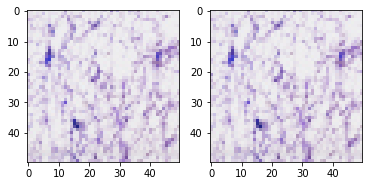

In [98]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(x[0])
ax[1].imshow(x_train_[0])

In [17]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [18]:
y = np.argmax(y_train, axis=1)
y[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
class_weights_ = compute_class_weight('balanced', np.unique(y), y)
d_class_weights = dict(enumerate(class_weights_))
d_class_weights

/Users/selenecamposlerida/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.6891829428558481, 1: 1.8214722015953242}

# Definición del modelo

In [53]:
# Editar arquitectura de la red:

model = Sequential()
model.add(Conv2D(filters=10, kernel_size=(3,3), input_shape=normed_dims+(3,),
                 activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3),
                 activation='relu', kernel_regularizer=regularizers.L2(0.1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(5,5),
                 activation='relu', kernel_regularizer=regularizers.L2(0.1)))
model.add(Conv2D(filters=64, kernel_size=(3,3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.6))
model.add(AveragePooling2D())
model.add(GlobalAveragePooling2D())

#model.add(Flatten()) # o Flatten o GlobalAveragePooling
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(10, activation='relu'))
model.add(Dense(2,activation='softmax'))


model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 10)        280       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 46, 46, 32)        2912      
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 19, 19, 64)        51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 17, 17, 64)       

In [45]:
number_train_samples = x_train.shape[0]
number_val_samples   = x_val.shape[0]
number_test_samples  = x_test.shape[0]

number_train_samples, number_val_samples, number_test_samples

(152082, 57151, 68291)

In [82]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(15,5)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=14)
    plt.ylabel('tasa de acierto (%)', fontsize=14)
    plt.xlabel('época', fontsize=14)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.xlabel('época', fontsize=14)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [47]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [48]:
modelpath="model_current_best_parte6.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [49]:
d_class_weights

{0: 0.6891829428558481, 1: 1.8214722015953242}

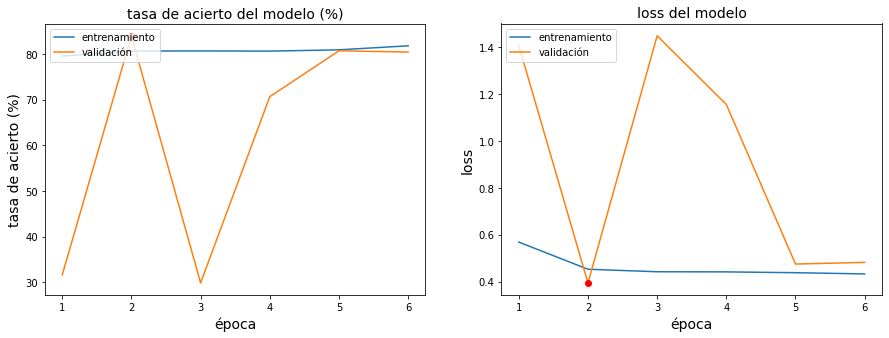

In [56]:
epochs = 5

for e in range(epochs):
    history = model.fit(x_train, y_train, 
                        epochs=1,
                        batch_size=64,
                        callbacks=callbacks_list,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        class_weight=d_class_weights
                       )
  
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0]) 
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

Las gráficas no contienen toda la información del entrenamiento, ya que se reiniciaba el entorno muchas veces.

# Resultados

In [226]:
LOAD_MODEL = False

In [227]:
if LOAD_MODEL:
    if COLAB:
        urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1UKpxwZsfPAp0kHywBucwWBtkxYAXy0lq",
                                   "modelo_entrenado.h5")
    model = load_model('./modelo_entrenado.h5')
else:
    model = load_model('model_current_best_parte6.h5')

In [228]:
scores_tr = model.evaluate(x_train, y_train)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(x_val, y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(x_test, y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

4753/4753 [==============================] - 209s 43ms/step - loss: 0.4027 - accuracy: 0.8317
Train loss    : 0.40270155668258667
Train accuracy: 0.8317223787307739

1786/1786 [==============================] - 74s 41ms/step - loss: 0.3941 - accuracy: 0.8398
Val loss    : 0.39410409331321716
Val accuracy: 0.8397753238677979

2135/2135 [==============================] - 93s 44ms/step - loss: 0.4366 - accuracy: 0.8195
Test loss     : 0.4366382360458374
Test accuracy : 0.8195369839668274


In [229]:
decision_threshold = 0.5

In [230]:
y_predict = model.predict(x_test)

In [231]:
alarmas = 1*(y_predict[:,1]>decision_threshold)
alarmas

array([1, 0, 0, ..., 0, 0, 0])

#### Matriz de confusión para un threshold de 0.3, 0.4 y 0.5 respectivamente

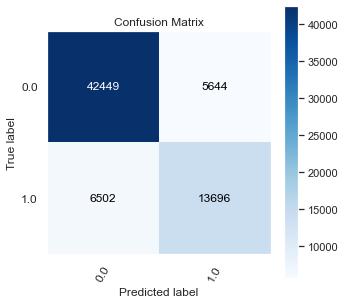

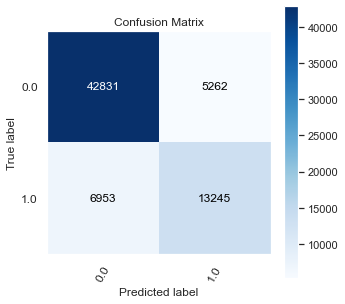

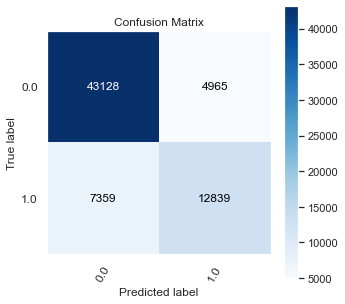

In [232]:
d = [0.3, 0.4, 0.5]
for i in range(3):
    decision_threshold = d[i]
    alarmas = 1*(y_predict[:,1]>decision_threshold)
    plot_confusion_matrix(y_test[:,1], alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large')

In [107]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [233]:

print('')
print(classification_report(y_test[:,1], alarmas))


              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87     48093
         1.0       0.72      0.64      0.68     20198

    accuracy                           0.82     68291
   macro avg       0.79      0.77      0.78     68291
weighted avg       0.81      0.82      0.82     68291



In [ ]:
y_pred_proba

array([[0.42990372, 0.5700963 ],
       [0.82656467, 0.17343529],
       [0.9924372 , 0.00756284],
       ...,
       [0.977457  , 0.02254308],
       [0.9948324 , 0.00516761],
       [0.9775468 , 0.0224532 ]], dtype=float32)

In [84]:
y = np.array(test_data.labels)
y = to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [64]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [65]:
alarmas

array([0, 0, 1, ..., 1, 1, 1])

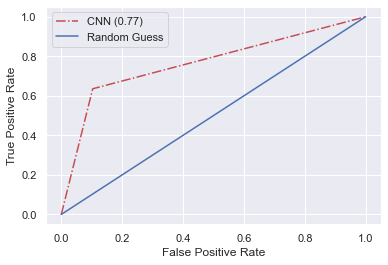

In [234]:
fpr, tpr, thresholds = roc_curve(y_test[:,1], alarmas)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# Intento de transfer learning

In [64]:
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.applications import VGG19

In [97]:
vgg19 = VGG19(weights='imagenet',  # Load weights pre-trained on ImageNet.
              input_shape=(50, 50, 3),
              include_top=False)
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [96]:
vgg19.trainable = False

In [99]:
inputs = keras.Input(shape=(50, 50, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = vgg19(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [103]:
modelpath="vgg_19_primera_prueba.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_data, 
          epochs=2, 
          verbose=1,
          callbacks=[checkpoint], 
          validation_data=val_data, 
          class_weight=class_weight)

Epoch 1/2
  19/1189 [..............................] - ETA: 2:40:49 - loss: 0.3474 - binary_accuracy: 0.5000

In [ ]:
vgg19 = VGG19(weights="imagenet", include_top=True)
input_layer = vgg19.layers[0]
block5_pool = vgg19.layers[21]
flatten = keras.layers.Flatten()(block5_pool.output)
dense_01 = keras.layers.Dense(units=1,activation="sigmoid")(flatten)
model = keras.Model(inputs=input_layer.output, outputs=dense_01, name="vgg19_rebuild")
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy())

In [135]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(50, 50, 3))

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(100)(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(10)(x)
outputs = keras.layers.Dense(2)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
normalization_5 (Normalizati (None, 50, 50, 3)         7         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               204900    
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1010

In [137]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


In [139]:
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/100
2377/2377 [==============================] - 990s 414ms/step - loss: 0.5637 - binary_accuracy: 0.7214 - val_loss: 0.5167 - val_binary_accuracy: 0.7361
Epoch 2/100
2377/2377 [==============================] - 853s 359ms/step - loss: 0.5178 - binary_accuracy: 0.7386 - val_loss: 0.5047 - val_binary_accuracy: 0.7408
Epoch 3/100
2377/2377 [==============================] - 827s 348ms/step - loss: 0.5100 - binary_accuracy: 0.7457 - val_loss: 0.4934 - val_binary_accuracy: 0.7527
Epoch 4/100
2377/2377 [==============================] - 852s 358ms/step - loss: 0.5041 - binary_accuracy: 0.7505 - val_loss: 0.4892 - val_binary_accuracy: 0.7566
Epoch 5/100
2377/2377 [==============================] - 830s 349ms/step - loss: 0.5065 - binary_accuracy: 0.7477 - val_loss: 0.4906 - val_binary_accuracy: 0.7533
Epoch 6/100
2377/2377 [==============================] - 817s 343ms/step - loss: 0.4950 - binary_accuracy: 0.7563 - val_loss: 0.4808 - val_binary_accuracy: 0.7634
Epoch 7/100
2377/2377 

KeyboardInterrupt: 

In [136]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 28987186815428689]

Al utilizar un modelo de *transfer learning* observamos que el tiempo de computación aumenta muchísimo y no se observan mejoras en los resultados. Así que, vamos a hacer lo que deberíamos haber hecho desde el principio. Empezar por un modelo más sencillo.

# Red con dos capas convolucionales

Primero se probó con una red con una capa convolucional de 5 filtros, seguida de una capa *Flatten* y una Densa. Se consiguió un 74% de *accuracy*.
Después se creó una red con una capa convolucional de 32 filtros, seguida de una capa *Flatten* y una Densa. Se consiguió un 82% de *accuracy*.
Estos modelos están en otro *notebook*

In [66]:
little_model = Sequential()

little_model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(50,50,3), activation='relu'))
little_model.add(MaxPooling2D())
little_model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(50,50,3), activation='relu', 
                        kernel_regularizer=regularizers.L2(0.1)))
little_model.add(Flatten())
little_model.add(Dense(2, activation='softmax'))

little_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 270850    
Total params: 290,242
Trainable params: 290,242
Non-trainable params: 0
_________________________________________________________________


In [30]:
little_model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])

In [31]:
little_modelpath="little_model_32_2.h5"

little_checkpoint = ModelCheckpoint(little_modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
little_callbacks_list = [little_checkpoint]

In [33]:
l_acum_tr_acc = []
l_acum_val_acc = []
l_best_val_acc = -1000
l_acum_tr_loss  = []
l_acum_val_loss = []

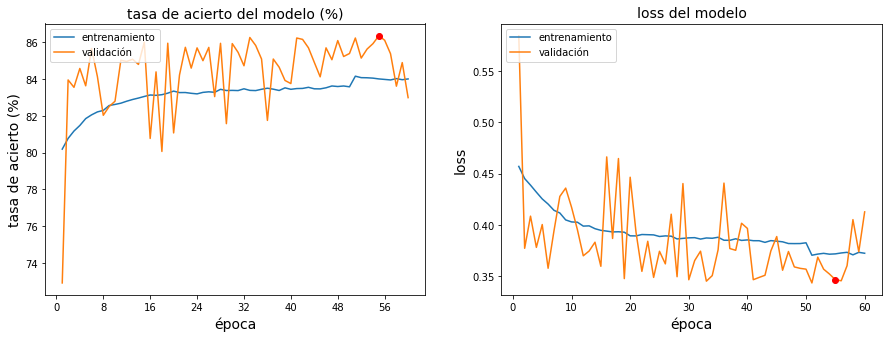

In [41]:
epochs = 5

for e in range(epochs):
    history = little_model.fit(x_train, y_train, 
                        epochs=1,
                        batch_size=256,
                        callbacks=little_callbacks_list,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        class_weight=d_class_weights
                       )
  
    if history.history['val_accuracy'][-1] > l_best_val_acc:
        print("Validation accuracy improved from",
            l_best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        l_best_val_acc = history.history['val_accuracy'][-1]
    
    l_acum_tr_acc.append(history.history['accuracy'][0])
    l_acum_val_acc.append(history.history['val_accuracy'][0])
    l_acum_tr_loss.append(history.history['loss'][0])
    l_acum_val_loss.append(history.history['val_loss'][0]) 
    
    if len(l_acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(l_acum_val_acc)
        grafica_entrenamiento(l_acum_tr_acc, l_acum_val_acc, l_acum_tr_loss, l_acum_val_loss, best_i)

## Resultados

In [20]:
# CARGAMOS EL MODELO 
model_r = load_model("32f-2l/little_model_32_2.h5")

In [240]:
scores_tr = model_r.evaluate(x_train, y_train)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model_r.evaluate(x_val, y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model_r.evaluate(x_test, y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

4753/4753 [==============================] - 83s 17ms/step - loss: 0.3420 - accuracy: 0.8552
Train loss    : 0.3420443534851074
Train accuracy: 0.8551965355873108

1786/1786 [==============================] - 34s 19ms/step - loss: 0.3466 - accuracy: 0.8636
Val loss    : 0.3465556800365448
Val accuracy: 0.8635544180870056

2135/2135 [==============================] - 33s 15ms/step - loss: 0.3684 - accuracy: 0.8459
Test loss     : 0.36837315559387207
Test accuracy : 0.8458801507949829


In [21]:
# Probabilidades de la predicción
y_predict = model_r.predict(x_test)

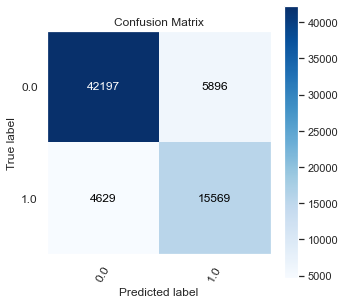

In [22]:
### Matriz de confusión
#threshold
th = 0.5
# Valores predichos
alarmas = 1*(y_predict[:,1]>th)

plot_confusion_matrix(y_test[:,1], alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large')

In [243]:
print(classification_report(y_test[:,1], alarmas))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     48093
         1.0       0.73      0.77      0.75     20198

    accuracy                           0.85     68291
   macro avg       0.81      0.82      0.82     68291
weighted avg       0.85      0.85      0.85     68291



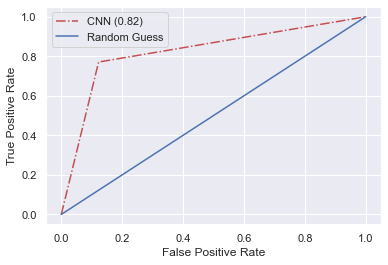

In [23]:
### ROC
fpr, tpr, thresholds = roc_curve(y_test[:,1], alarmas)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# Resultados de un modelo con 3 capas convolucionales
Este modelo fue definido y entreado en un *notebook* diferente

In [25]:
model_r = load_model("models/little_model_32_batchn-3.h5")
model_r.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        2

In [26]:
# Probabilidades de la predicción
y_predict = model_r.predict(x_test)

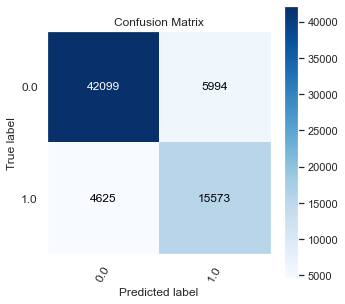

In [27]:
### Matriz de confusión
#threshold
th = 0.5
# Valores predichos
alarmas = 1*(y_predict[:,1]>th)

plot_confusion_matrix(y_test[:,1], alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large')

In [28]:
print(classification_report(y_test[:,1], alarmas))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     48093
         1.0       0.72      0.77      0.75     20198

    accuracy                           0.84     68291
   macro avg       0.81      0.82      0.82     68291
weighted avg       0.85      0.84      0.85     68291



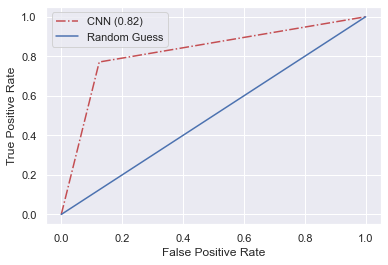

In [29]:
### ROC
fpr, tpr, thresholds = roc_curve(y_test[:,1], alarmas)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# Modelo final

Hasta llegar a este modelo, se fueron agregando capas y visualizando resultados.

In [235]:
loaded_model = load_model("little_model_32_batchn-3.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        2

In [236]:
loaded_model.pop()
loaded_model.pop()
loaded_model.add(BatchNormalization())
loaded_model.add(MaxPooling2D())
loaded_model.add(Dropout(0.5))
loaded_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                        kernel_regularizer=regularizers.L2(0.01)))

loaded_model.add(Flatten())
loaded_model.add(Dense(2, activation='softmax'))
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        2

In [ ]:
for i in range(4):
    loaded_model.layers[i].trainable = False
    print(loaded_model.layers[i].trainable)

In [198]:
loaded_model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])
loaded_modelpath="little_model_32_batchn-4.h5"

loaded_checkpoint = ModelCheckpoint(loaded_modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
loaded_callbacks_list = [loaded_checkpoint]

In [199]:
l_acum_tr_acc = []
l_acum_val_acc = []
l_best_val_acc = -1000
l_acum_tr_loss  = []
l_acum_val_loss = []

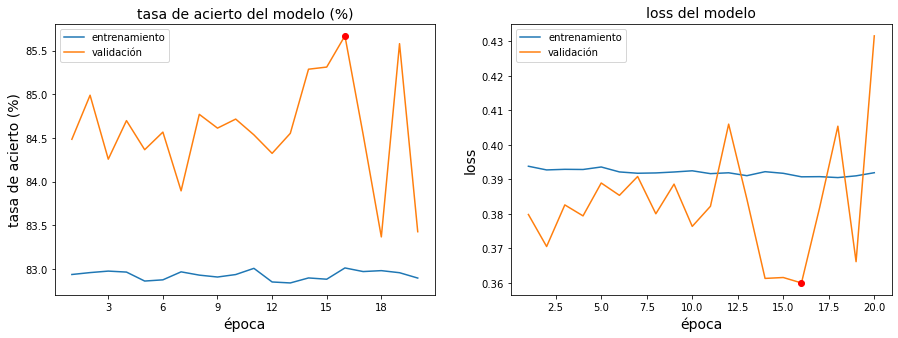

In [203]:
epochs = 15

for e in range(epochs):
    history = loaded_model.fit(x_train, y_train, 
                        epochs=1,
                        batch_size=256,
                        callbacks=loaded_callbacks_list,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        class_weight=d_class_weights
                       )
  
    if history.history['val_accuracy'][-1] > l_best_val_acc:
        print("Validation accuracy improved from",
            l_best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        l_best_val_acc = history.history['val_accuracy'][-1]
    
    l_acum_tr_acc.append(history.history['accuracy'][0])
    l_acum_val_acc.append(history.history['val_accuracy'][0])
    l_acum_tr_loss.append(history.history['loss'][0])
    l_acum_val_loss.append(history.history['val_loss'][0]) 
    
    if len(l_acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(l_acum_val_acc)
        grafica_entrenamiento(l_acum_tr_acc, l_acum_val_acc, l_acum_tr_loss, l_acum_val_loss, best_i)

In [201]:
history = loaded_model.fit(x_train, y_train, 
                        epochs=5,
                        batch_size=256,
                        callbacks=loaded_callbacks_list,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        class_weight=d_class_weights
                       )

Epoch 1/5
595/595 [==============================] - 349s 557ms/step - loss: 0.5078 - accuracy: 0.8215 - val_loss: 0.3749 - val_accuracy: 0.8447

Epoch 00001: val_accuracy improved from -inf to 0.84474, saving model to little_model_32_batchn-4.h5
Epoch 2/5
595/595 [==============================] - 319s 537ms/step - loss: 0.3986 - accuracy: 0.8279 - val_loss: 0.3803 - val_accuracy: 0.8525

Epoch 00002: val_accuracy improved from 0.84474 to 0.85251, saving model to little_model_32_batchn-4.h5
Epoch 3/5
595/595 [==============================] - 323s 542ms/step - loss: 0.3954 - accuracy: 0.8314 - val_loss: 0.4138 - val_accuracy: 0.8259

Epoch 00003: val_accuracy did not improve from 0.85251
Epoch 4/5
595/595 [==============================] - 314s 528ms/step - loss: 0.3945 - accuracy: 0.8274 - val_loss: 0.3925 - val_accuracy: 0.8387

Epoch 00004: val_accuracy did not improve from 0.85251
Epoch 5/5
595/595 [==============================] - 307s 515ms/step - loss: 0.3970 - accuracy: 0.827

# RESULTADOS

In [31]:
# CARGAMOS EL MODELO 
model_r = load_model("models/little_model_32_batchn-4.h5")

In [246]:
scores_tr = model_r.evaluate(x_train, y_train)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model_r.evaluate(x_val, y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model_r.evaluate(x_test, y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

4753/4753 [==============================] - 210s 43ms/step - loss: 0.3612 - accuracy: 0.8479
Train loss    : 0.3611721098423004
Train accuracy: 0.8478649854660034

1786/1786 [==============================] - 65s 36ms/step - loss: 0.3600 - accuracy: 0.8567
Val loss    : 0.36000344157218933
Val accuracy: 0.8566779494285583

2135/2135 [==============================] - 79s 37ms/step - loss: 0.3814 - accuracy: 0.8400
Test loss     : 0.3814317584037781
Test accuracy : 0.8399642705917358


In [32]:
# Probabilidades de la predicción
y_predict = model_r.predict(x_test)

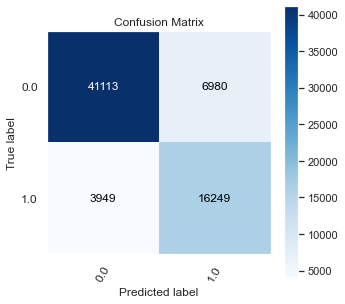

In [33]:
### Matriz de confusión
#threshold
th = 0.5
# Valores predichos
alarmas = 1*(y_predict[:,1]>th)

plot_confusion_matrix(y_test[:,1], alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large')

In [34]:
print(classification_report(y_test[:,1], alarmas))

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     48093
         1.0       0.70      0.80      0.75     20198

    accuracy                           0.84     68291
   macro avg       0.81      0.83      0.82     68291
weighted avg       0.85      0.84      0.84     68291



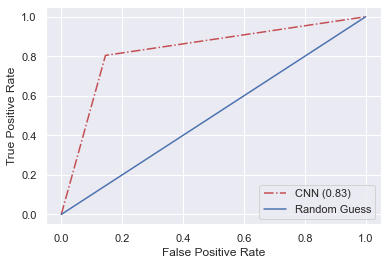

In [35]:
### ROC
fpr, tpr, thresholds = roc_curve(y_test[:,1], alarmas)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# Visualización de los filtros

Probabilidad sano: 86.9%
Probabilidad cancer : 13.1%
[1. 0.]


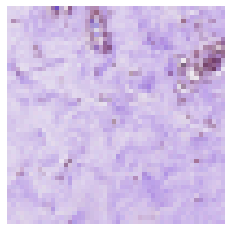

In [162]:
image = x_train[100].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model_r.predict(np.expand_dims(image, axis=0))[0][0]
print("Probabilidad sano: {:2.1f}%".format(100*p))
p = model_r.predict(np.expand_dims(image, axis=0))[0][1]
print("Probabilidad cancer : {:2.1f}%".format(100*p))
print(y_train[100])

In [36]:
# cargamos los pesos
weights = model_r.get_weights()
for i,w in enumerate(weights):
    print('shape of weights[%d]: ' %i, w.shape)

shape of weights[0]:  (3, 3, 3, 32)
shape of weights[1]:  (32,)
shape of weights[2]:  (3, 3, 32, 64)
shape of weights[3]:  (64,)
shape of weights[4]:  (64,)
shape of weights[5]:  (64,)
shape of weights[6]:  (64,)
shape of weights[7]:  (64,)
shape of weights[8]:  (3, 3, 64, 64)
shape of weights[9]:  (64,)
shape of weights[10]:  (64,)
shape of weights[11]:  (64,)
shape of weights[12]:  (64,)
shape of weights[13]:  (64,)
shape of weights[14]:  (3, 3, 64, 128)
shape of weights[15]:  (128,)
shape of weights[16]:  (128,)
shape of weights[17]:  (128,)
shape of weights[18]:  (128,)
shape of weights[19]:  (128,)
shape of weights[20]:  (3, 3, 128, 32)
shape of weights[21]:  (32,)
shape of weights[22]:  (128, 2)
shape of weights[23]:  (2,)


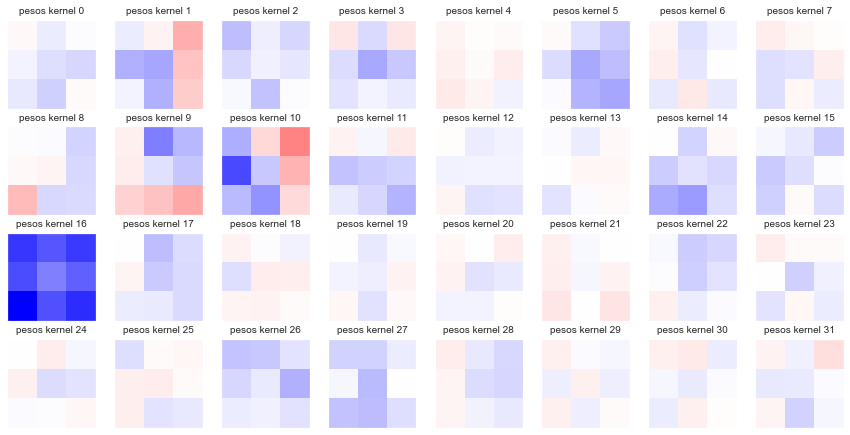

In [37]:
# kernels de la capa convolucional
nlayer = 0
nfilters = weights[nlayer].shape[3]

max_w = abs(weights[nlayer]).max()

ncols = 8
nrows = int(np.ceil(nfilters/ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(15,15*nrows/ncols))
ax = ax.ravel()

for i in range(nfilters):
    kernel = weights[nlayer][:,:,2,i]
    ax[i].imshow(kernel, vmin=-max_w, vmax=max_w, cmap='bwr')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('pesos kernel %d' %i, fontsize=10)

### **Visualización de las salidas de una sola capa**

In [273]:
# salida de una sola capa
nlayer = 2
intermediate_layer_model = Model(inputs=model_r.input,
                                 outputs=model_r.layers[nlayer].output)
intermediate_layer_model.summary()
print("\n\n")
display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True)))
#display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

Model: "model_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
Total params: 19,392
Trainable params: 0
Non-trainable params: 19,392
_________________________________________________________________



('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


<IPython.core.display.SVG object>

In [130]:
!pip install pydot

In [41]:
imagen = x_train[1005]
imagen.shape

(50, 50, 3)

In [139]:
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)
salida_capa.shape

(1, 22, 22, 64)

In [140]:
print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

Salidas capa batch_normalization (1, 22, 22, 64)


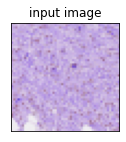

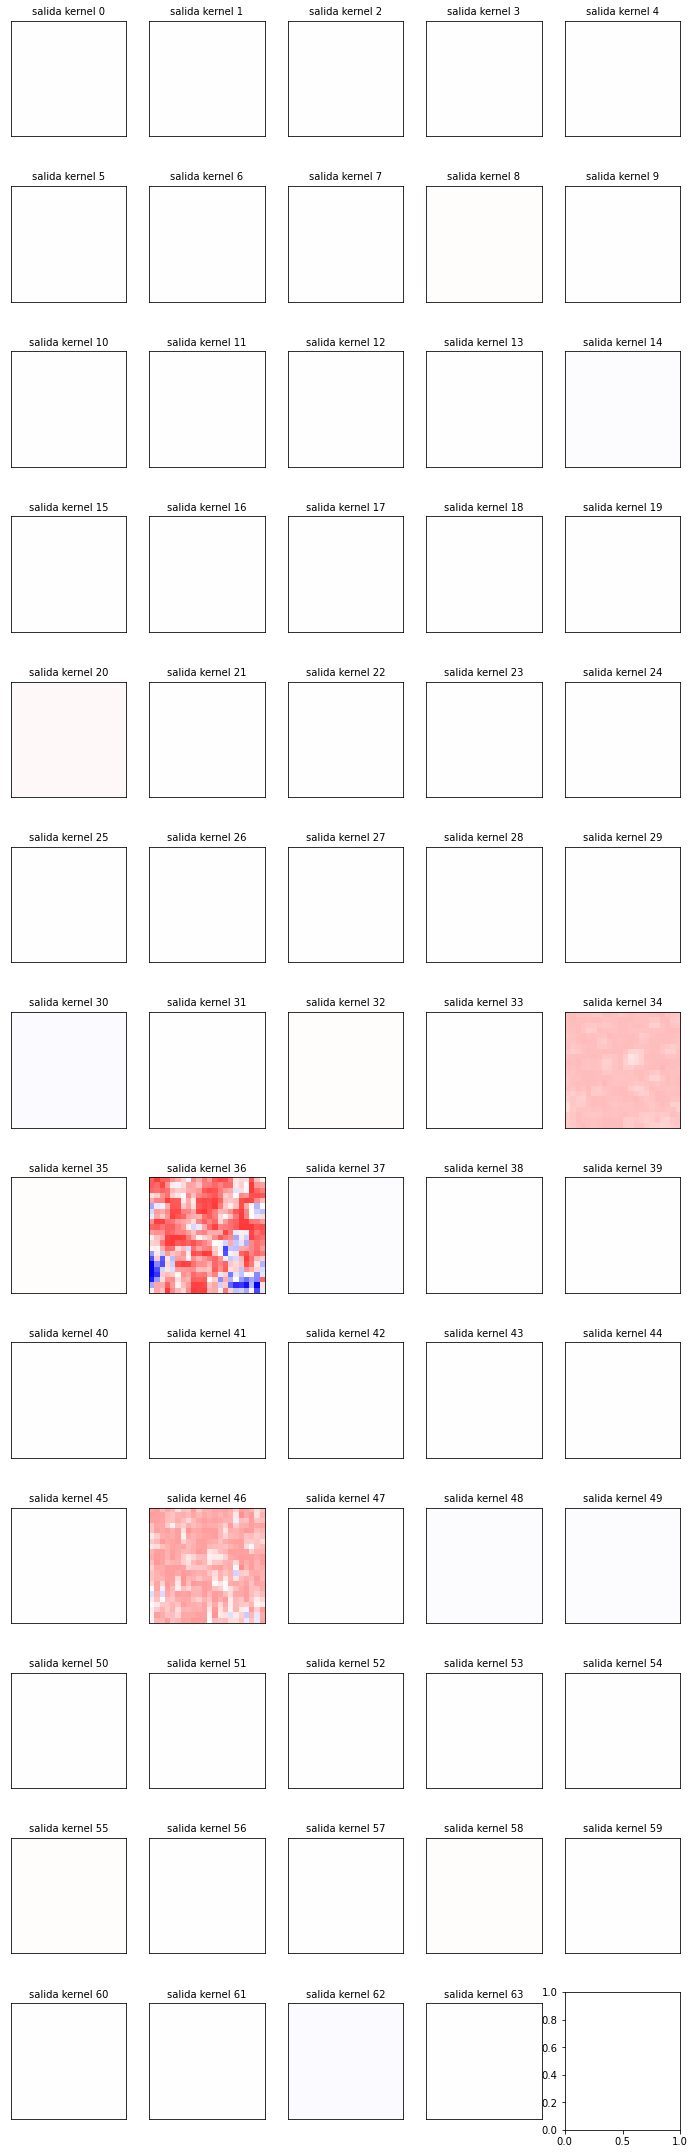

In [141]:
ma = abs(salida_capa).max()

nsalidas = salida_capa.shape[-1]
ncols = 5
nrows = int(np.ceil(nsalidas / ncols))

plt.figure(figsize=(2,2))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

# Salida de varias capas

In [43]:
n = 17
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model_r.layers[:n]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_r.input, outputs=layer_outputs)

activations = activation_model.predict(x_test[n:(n+1)])

<ipython-input-44-63ff4e8e437f>:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
<ipython-input-44-63ff4e8e437f>:28: RuntimeWarning: divide by zero encountered in true_divide
  channel_image /= channel_image.std()


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

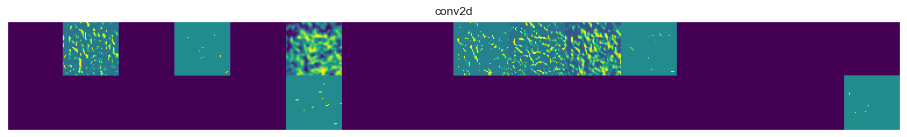

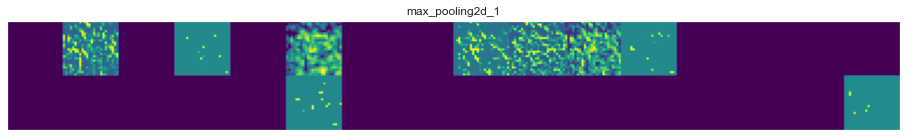

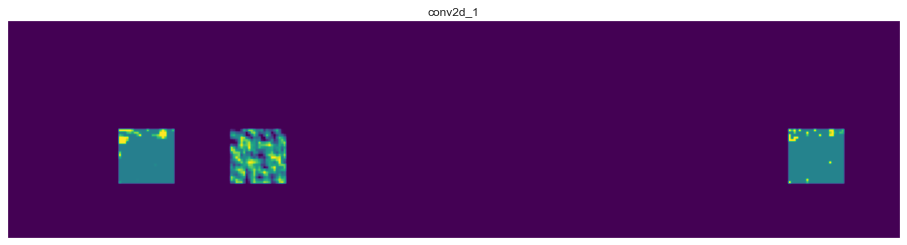

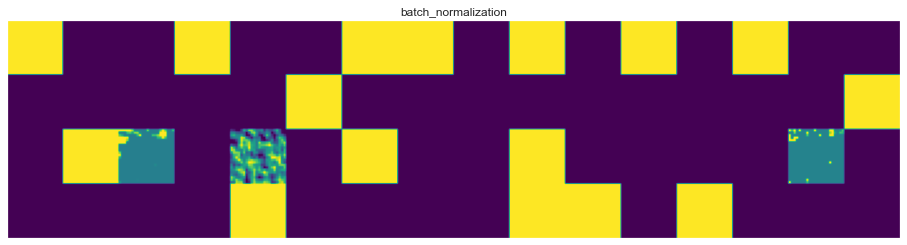

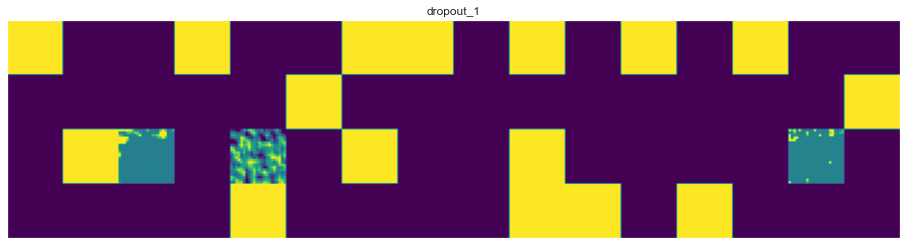

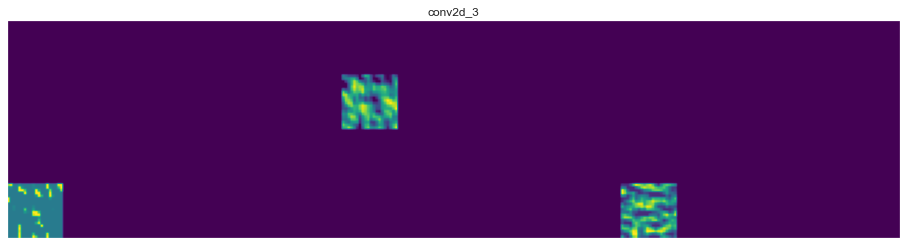

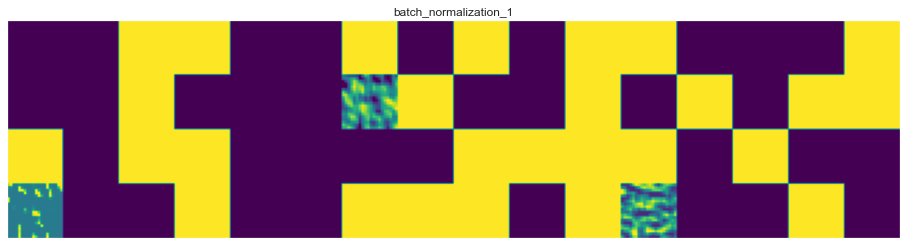

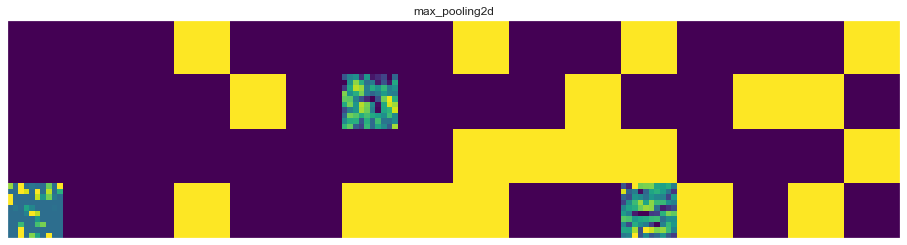

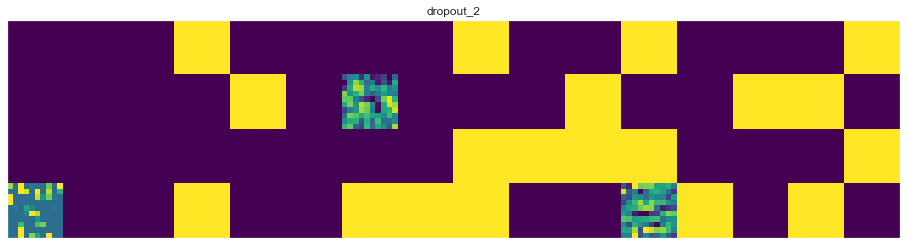

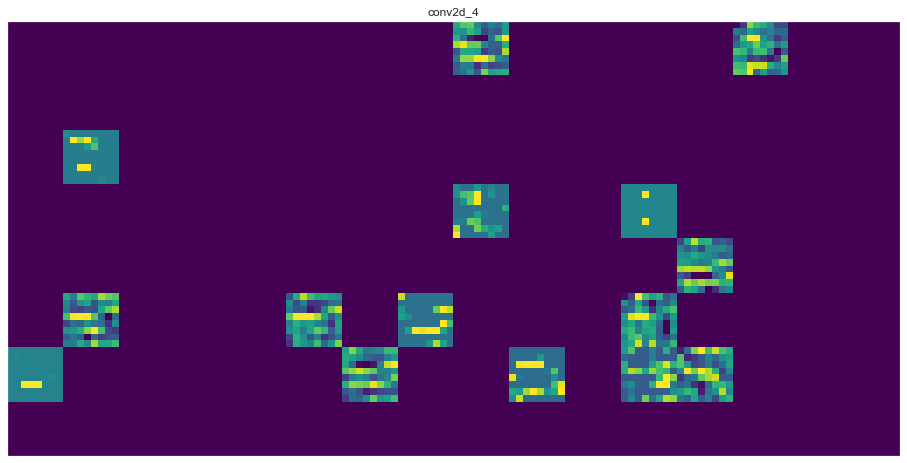

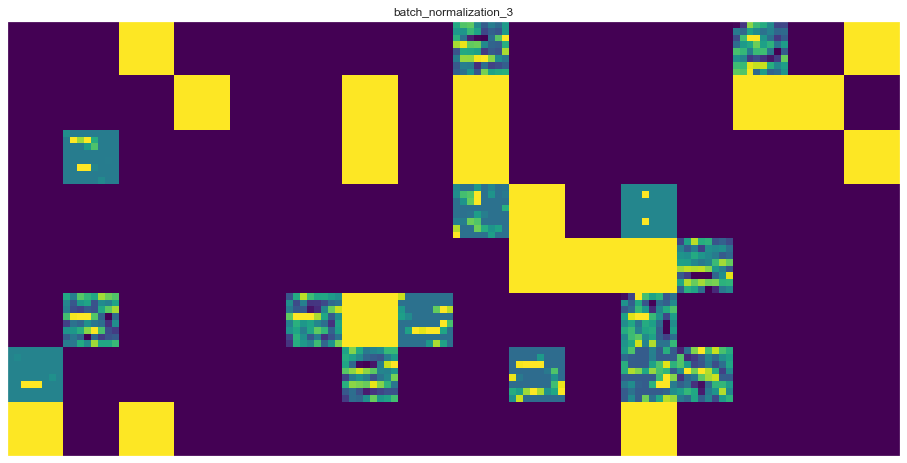

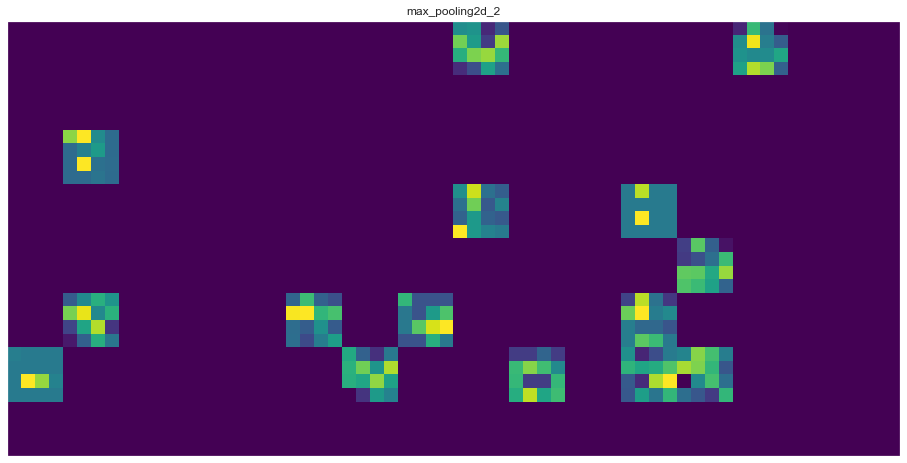

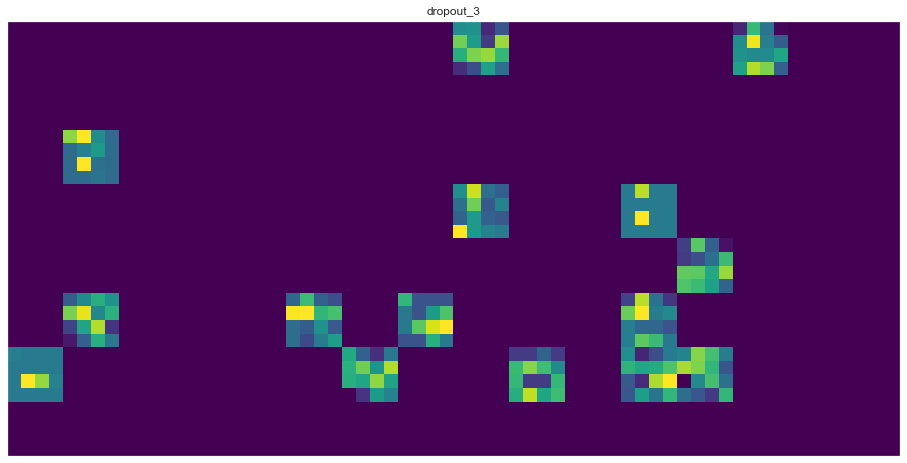

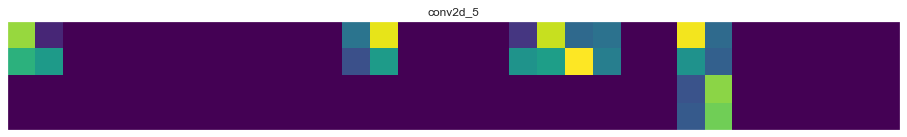

In [44]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_r.layers[:n]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [34]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im, clase):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    print('clase', clase)
    prob = 100*model.predict(imag)[0][0]
    print(model.predict(imag))
    print("Probabilidad clase sano : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][1]
    print("Probabilidad clase cancer: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

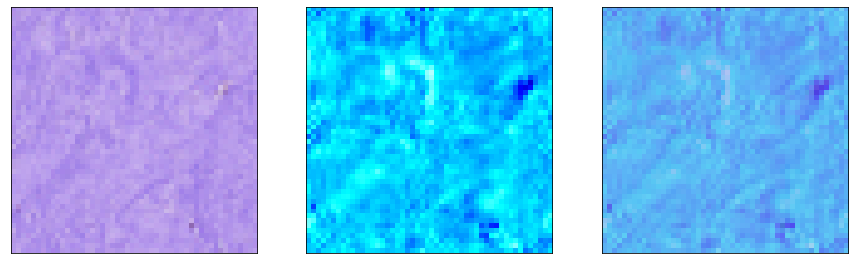

clase [1. 0.]
[[0.9491165  0.05088345]]
Probabilidad clase sano : 94.9%
Probabilidad clase cancer: 5.1%





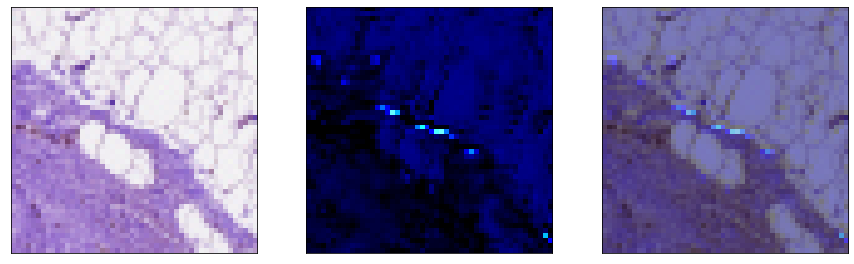

clase [1. 0.]
[[0.80745715 0.19254279]]
Probabilidad clase sano : 80.7%
Probabilidad clase cancer: 19.3%





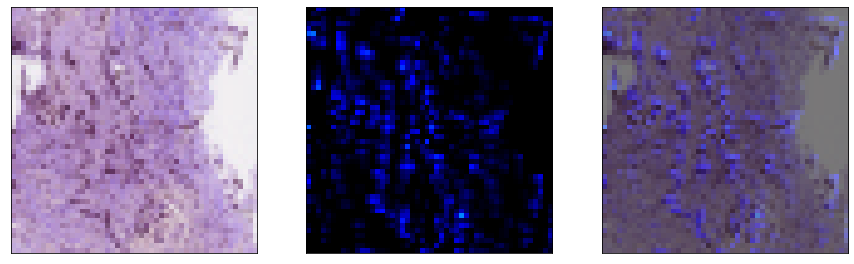

clase [1. 0.]
[[0.3949572 0.6050428]]
Probabilidad clase sano : 39.5%
Probabilidad clase cancer: 60.5%





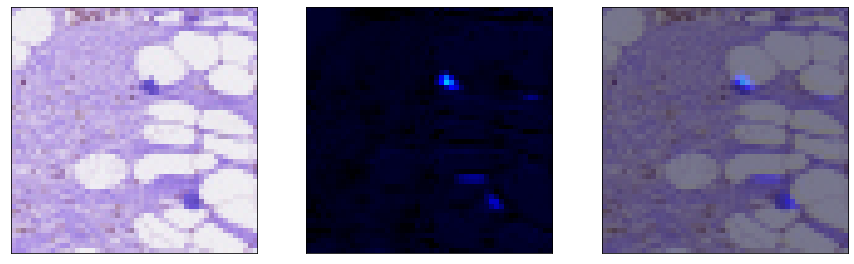

clase [1. 0.]
[[0.8611864  0.13881367]]
Probabilidad clase sano : 86.1%
Probabilidad clase cancer: 13.9%





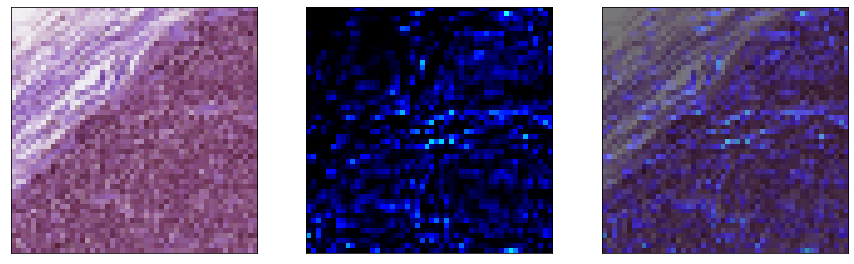

clase [0. 1.]
[[0.2024035 0.7975965]]
Probabilidad clase sano : 20.2%
Probabilidad clase cancer: 79.8%





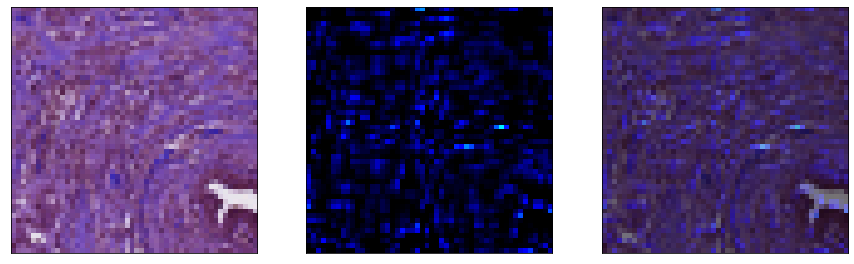

clase [0. 1.]
[[0.22456563 0.7754344 ]]
Probabilidad clase sano : 22.5%
Probabilidad clase cancer: 77.5%





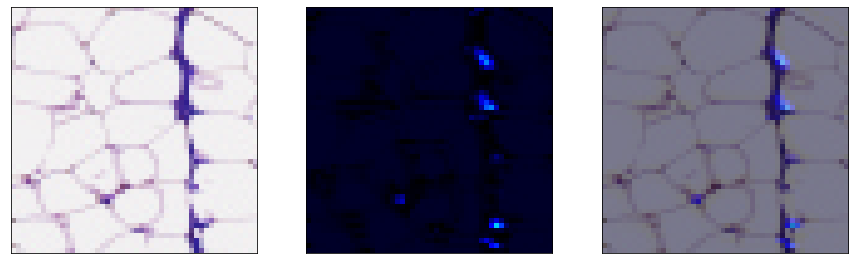

clase [1. 0.]
[[0.95781535 0.04218467]]
Probabilidad clase sano : 95.8%
Probabilidad clase cancer: 4.2%





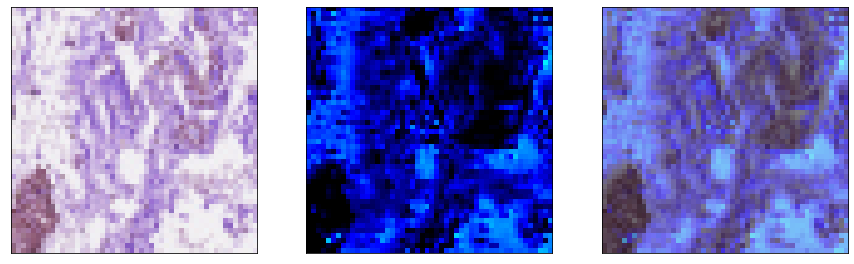

clase [1. 0.]
[[0.54568315 0.45431685]]
Probabilidad clase sano : 54.6%
Probabilidad clase cancer: 45.4%





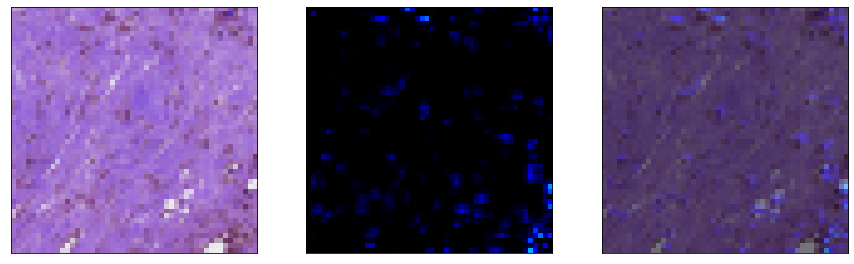

clase [1. 0.]
[[0.3554164  0.64458364]]
Probabilidad clase sano : 35.5%
Probabilidad clase cancer: 64.5%





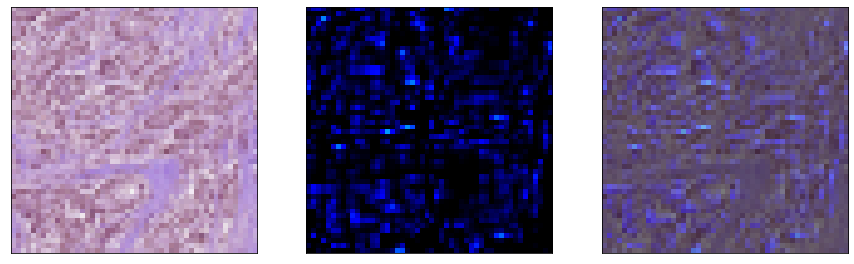

clase [0. 1.]
[[0.10747788 0.8925221 ]]
Probabilidad clase sano : 10.7%
Probabilidad clase cancer: 89.3%





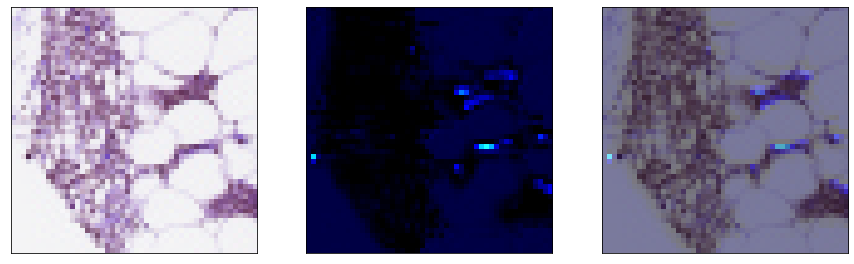

clase [0. 1.]
[[0.88752854 0.11247153]]
Probabilidad clase sano : 88.8%
Probabilidad clase cancer: 11.2%





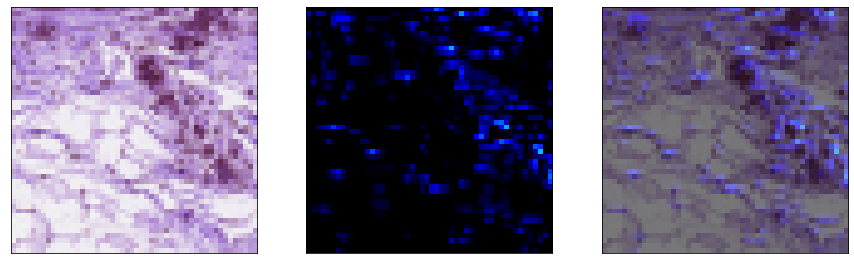

clase [1. 0.]
[[0.3754994 0.6245006]]
Probabilidad clase sano : 37.5%
Probabilidad clase cancer: 62.5%





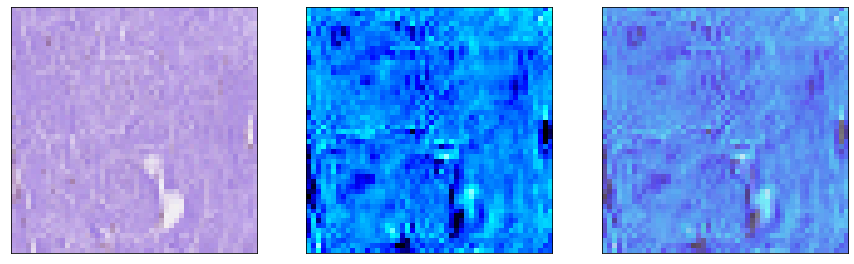

clase [1. 0.]
[[0.86593825 0.13406175]]
Probabilidad clase sano : 86.6%
Probabilidad clase cancer: 13.4%





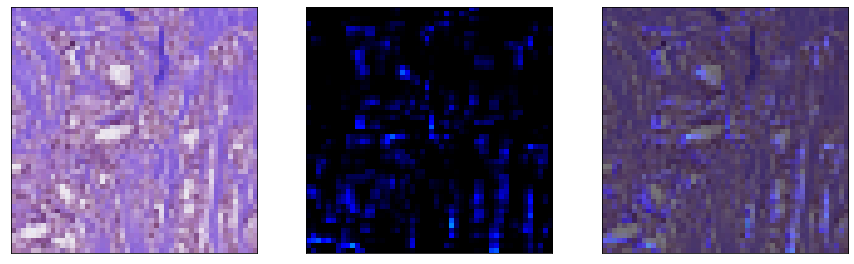

clase [0. 1.]
[[0.4624439 0.5375561]]
Probabilidad clase sano : 46.2%
Probabilidad clase cancer: 53.8%





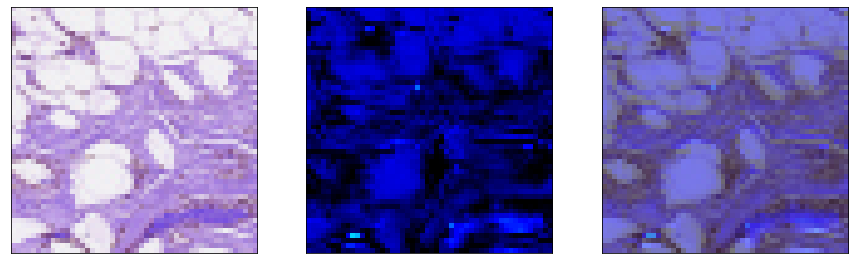

clase [1. 0.]
[[0.64366543 0.35633466]]
Probabilidad clase sano : 64.4%
Probabilidad clase cancer: 35.6%





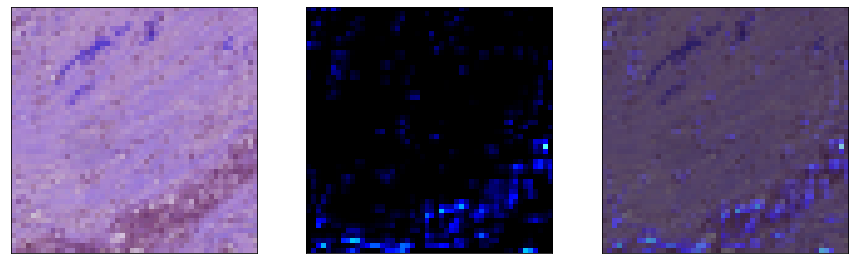

clase [0. 1.]
[[0.3046474 0.6953527]]
Probabilidad clase sano : 30.5%
Probabilidad clase cancer: 69.5%





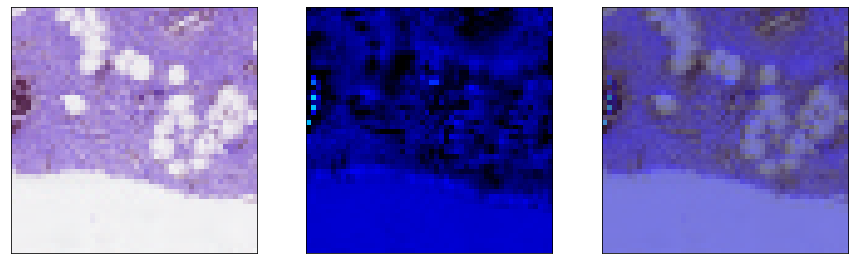

clase [1. 0.]
[[0.8661308  0.13386919]]
Probabilidad clase sano : 86.6%
Probabilidad clase cancer: 13.4%





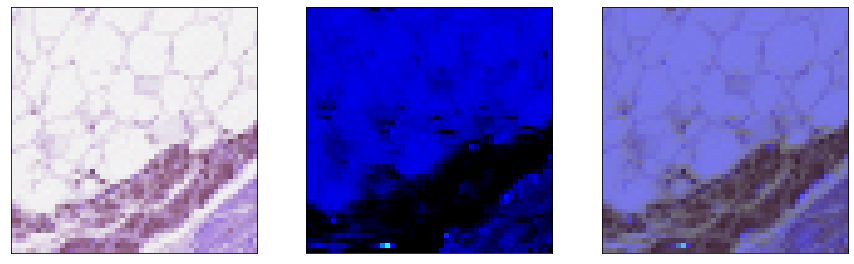

clase [1. 0.]
[[0.77191865 0.22808136]]
Probabilidad clase sano : 77.2%
Probabilidad clase cancer: 22.8%





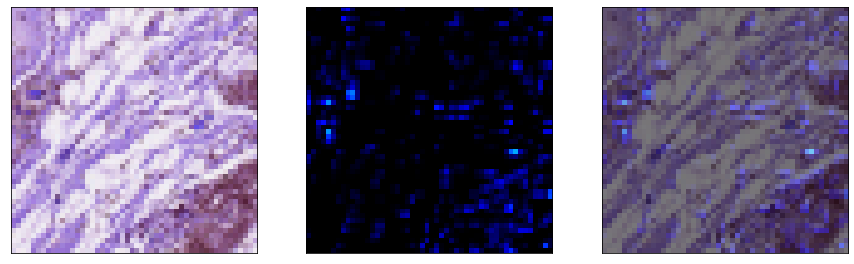

clase [1. 0.]
[[0.21572551 0.7842745 ]]
Probabilidad clase sano : 21.6%
Probabilidad clase cancer: 78.4%





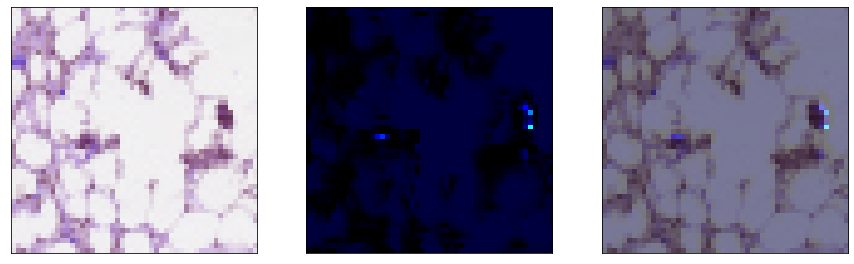

clase [0. 1.]
[[0.65946823 0.34053177]]
Probabilidad clase sano : 65.9%
Probabilidad clase cancer: 34.1%





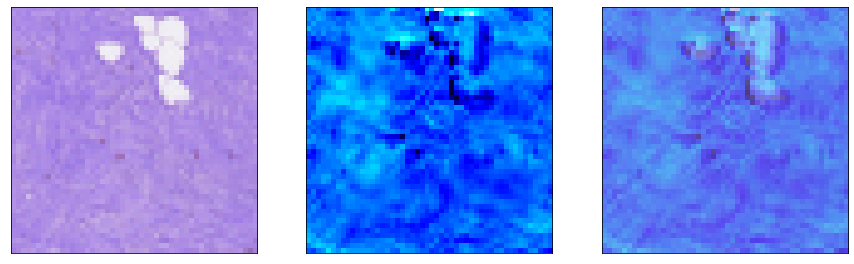

clase [1. 0.]
[[0.92581236 0.07418761]]
Probabilidad clase sano : 92.6%
Probabilidad clase cancer: 7.4%





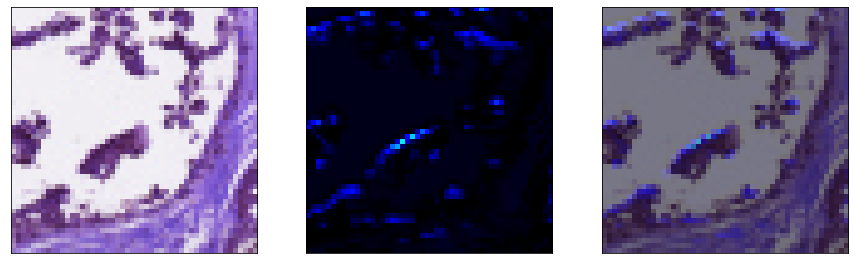

clase [1. 0.]
[[0.8956945  0.10430545]]
Probabilidad clase sano : 89.6%
Probabilidad clase cancer: 10.4%





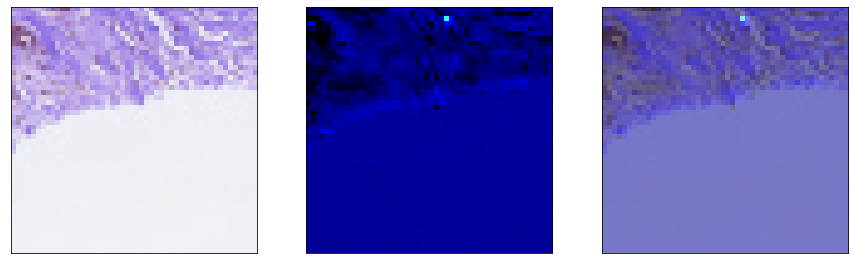

clase [0. 1.]
[[0.95543134 0.0445687 ]]
Probabilidad clase sano : 95.5%
Probabilidad clase cancer: 4.5%





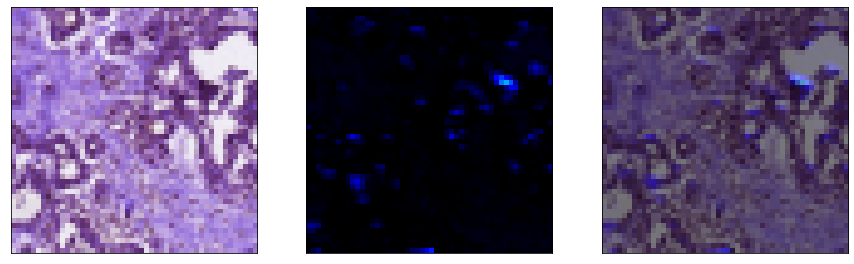

clase [1. 0.]
[[0.66334486 0.33665514]]
Probabilidad clase sano : 66.3%
Probabilidad clase cancer: 33.7%





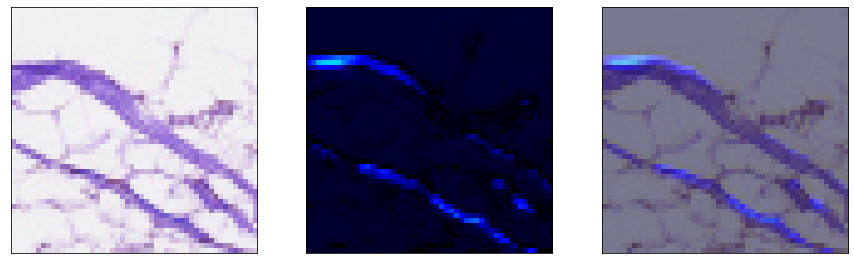

clase [1. 0.]
[[0.9724345  0.02756556]]
Probabilidad clase sano : 97.2%
Probabilidad clase cancer: 2.8%





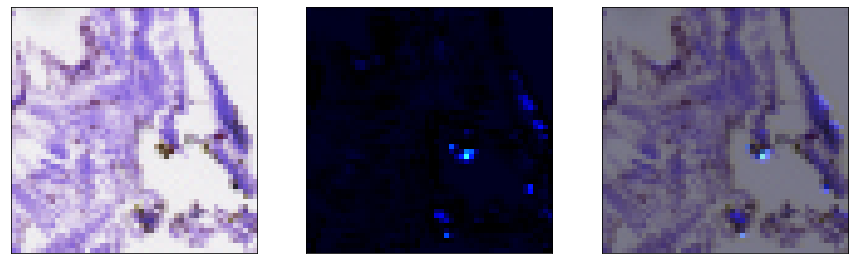

clase [1. 0.]
[[0.9086499  0.09135008]]
Probabilidad clase sano : 90.9%
Probabilidad clase cancer: 9.1%





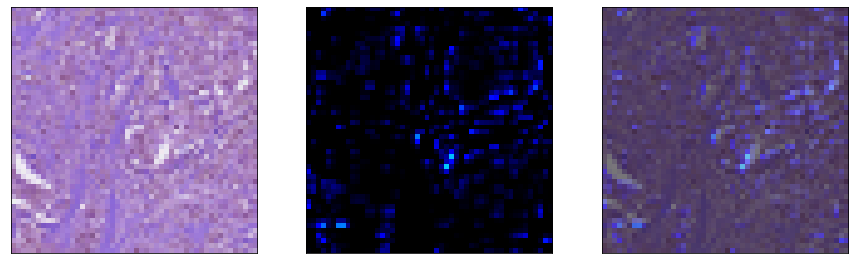

clase [0. 1.]
[[0.28066176 0.71933824]]
Probabilidad clase sano : 28.1%
Probabilidad clase cancer: 71.9%





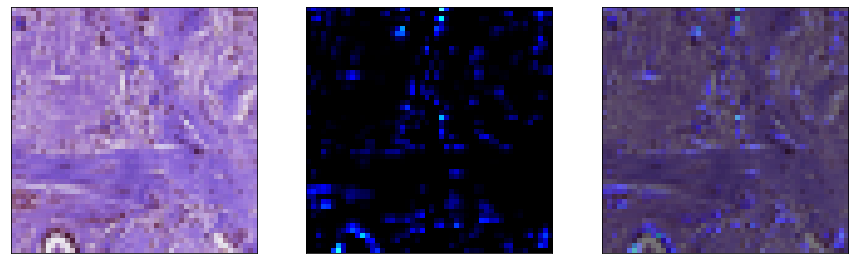

clase [1. 0.]
[[0.40817112 0.59182894]]
Probabilidad clase sano : 40.8%
Probabilidad clase cancer: 59.2%





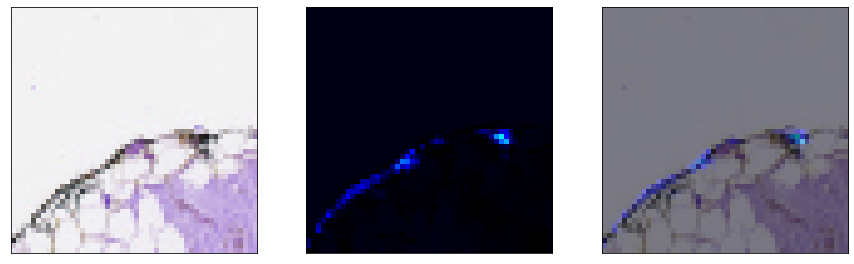

clase [1. 0.]
[[0.9670847  0.03291528]]
Probabilidad clase sano : 96.7%
Probabilidad clase cancer: 3.3%





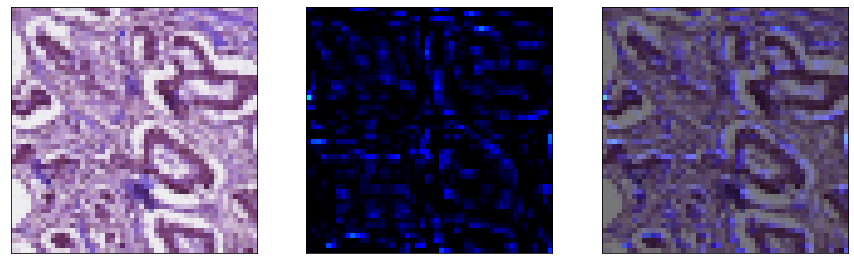

clase [0. 1.]
[[0.45081934 0.5491806 ]]
Probabilidad clase sano : 45.1%
Probabilidad clase cancer: 54.9%





In [47]:
#resultados del modelo con 1 capa convolucional de 32 filtros.
for i in range(20, 50):
    show_heatmap(model_r, x_train[i], y_train[i])

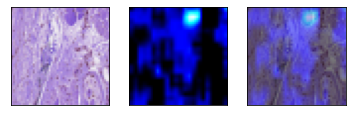

clase [0. 1.]
[[0.6884511 0.3115489]]
Probabilidad clase sano : 68.8%
Probabilidad clase cancer: 31.2%





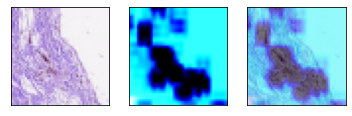

clase [1. 0.]
[[0.9365578  0.06344221]]
Probabilidad clase sano : 93.7%
Probabilidad clase cancer: 6.3%





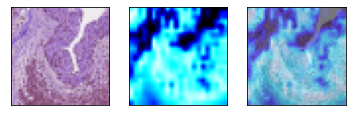

clase [1. 0.]
[[0.06552175 0.9344782 ]]
Probabilidad clase sano : 6.6%
Probabilidad clase cancer: 93.4%





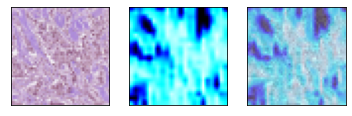

clase [0. 1.]
[[0.05370475 0.9462952 ]]
Probabilidad clase sano : 5.4%
Probabilidad clase cancer: 94.6%





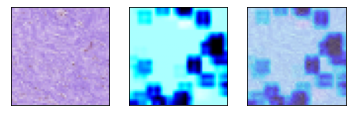

clase [1. 0.]
[[0.909915   0.09008504]]
Probabilidad clase sano : 91.0%
Probabilidad clase cancer: 9.0%





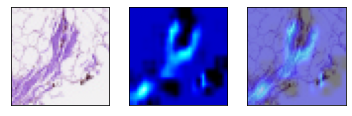

clase [1. 0.]
[[0.9470028  0.05299713]]
Probabilidad clase sano : 94.7%
Probabilidad clase cancer: 5.3%





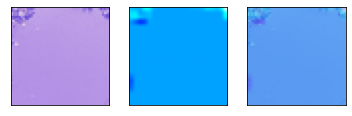

clase [0. 1.]
[[0.9463786  0.05362143]]
Probabilidad clase sano : 94.6%
Probabilidad clase cancer: 5.4%





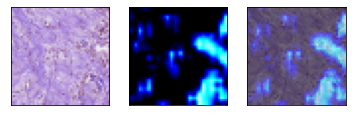

clase [0. 1.]
[[0.38486934 0.61513066]]
Probabilidad clase sano : 38.5%
Probabilidad clase cancer: 61.5%





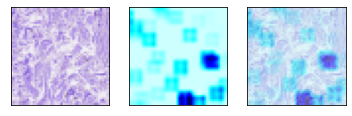

clase [1. 0.]
[[0.9376235  0.06237646]]
Probabilidad clase sano : 93.8%
Probabilidad clase cancer: 6.2%





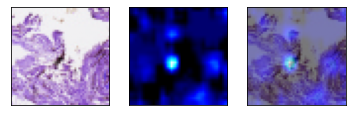

clase [1. 0.]
[[0.93296343 0.06703658]]
Probabilidad clase sano : 93.3%
Probabilidad clase cancer: 6.7%





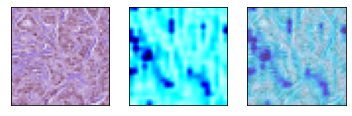

clase [0. 1.]
[[0.0243952 0.9756048]]
Probabilidad clase sano : 2.4%
Probabilidad clase cancer: 97.6%





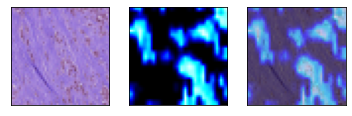

clase [0. 1.]
[[0.22708328 0.7729168 ]]
Probabilidad clase sano : 22.7%
Probabilidad clase cancer: 77.3%





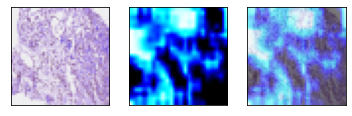

clase [1. 0.]
[[0.7083625 0.2916375]]
Probabilidad clase sano : 70.8%
Probabilidad clase cancer: 29.2%





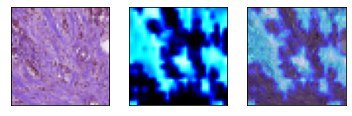

clase [0. 1.]
[[0.22258653 0.7774134 ]]
Probabilidad clase sano : 22.3%
Probabilidad clase cancer: 77.7%





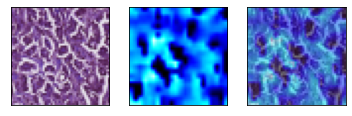

clase [0. 1.]
[[0.14770712 0.85229284]]
Probabilidad clase sano : 14.8%
Probabilidad clase cancer: 85.2%





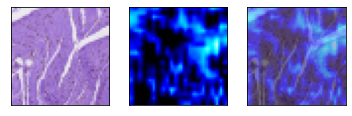

clase [1. 0.]
[[0.8078592  0.19214079]]
Probabilidad clase sano : 80.8%
Probabilidad clase cancer: 19.2%





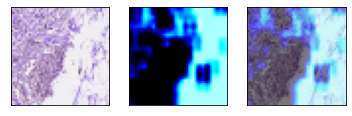

clase [0. 1.]
[[0.7316809  0.26831898]]
Probabilidad clase sano : 73.2%
Probabilidad clase cancer: 26.8%





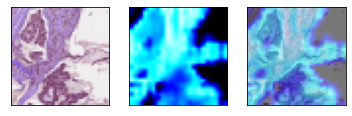

clase [0. 1.]
[[0.22174917 0.7782508 ]]
Probabilidad clase sano : 22.2%
Probabilidad clase cancer: 77.8%





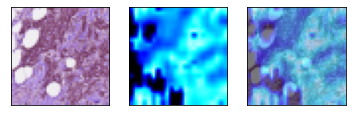

clase [0. 1.]
[[0.12790069 0.8720993 ]]
Probabilidad clase sano : 12.8%
Probabilidad clase cancer: 87.2%





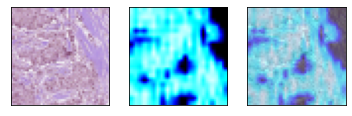

clase [0. 1.]
[[0.09373022 0.9062698 ]]
Probabilidad clase sano : 9.4%
Probabilidad clase cancer: 90.6%





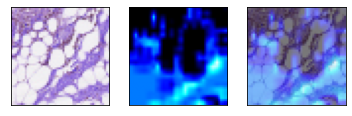

clase [1. 0.]
[[0.7019211 0.2980789]]
Probabilidad clase sano : 70.2%
Probabilidad clase cancer: 29.8%





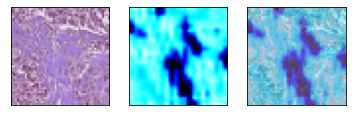

clase [0. 1.]
[[0.02254282 0.97745717]]
Probabilidad clase sano : 2.3%
Probabilidad clase cancer: 97.7%





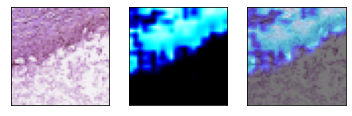

clase [1. 0.]
[[0.46746853 0.53253144]]
Probabilidad clase sano : 46.7%
Probabilidad clase cancer: 53.3%





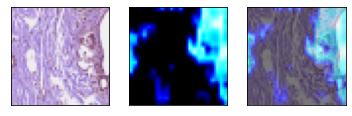

clase [1. 0.]
[[0.2696367 0.7303633]]
Probabilidad clase sano : 27.0%
Probabilidad clase cancer: 73.0%





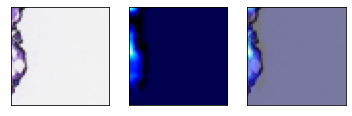

clase [1. 0.]
[[0.98956174 0.01043823]]
Probabilidad clase sano : 99.0%
Probabilidad clase cancer: 1.0%





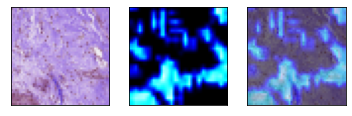

clase [1. 0.]
[[0.37248307 0.627517  ]]
Probabilidad clase sano : 37.2%
Probabilidad clase cancer: 62.8%





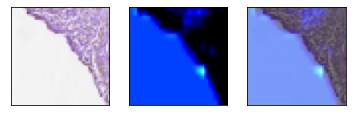

clase [1. 0.]
[[0.71228623 0.2877138 ]]
Probabilidad clase sano : 71.2%
Probabilidad clase cancer: 28.8%





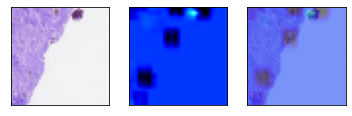

clase [1. 0.]
[[0.9112808  0.08871911]]
Probabilidad clase sano : 91.1%
Probabilidad clase cancer: 8.9%





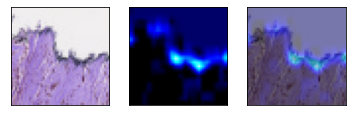

clase [1. 0.]
[[0.80276865 0.19723131]]
Probabilidad clase sano : 80.3%
Probabilidad clase cancer: 19.7%





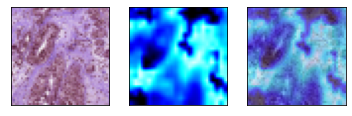

clase [1. 0.]
[[0.11441498 0.88558507]]
Probabilidad clase sano : 11.4%
Probabilidad clase cancer: 88.6%





In [144]:
#resultados del último modelo propuesto.
for i in range(20, 50):
    show_heatmap(model_r, x_test[i], y_test[i])